In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import glob
import matplotlib.pyplot as plt
import nilearn.image, nilearn.masking, nilearn.plotting
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import statsmodels.stats.multitest
import nilearn.plotting
import pickle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: Fut

In [2]:
data_dir = '/Volumes/clmnlab/GA/MVPA/LSS_pb02_MO_short_duration/data/'

In [2]:
subj_list = [
    'GA01', 'GA02', 'GA05', 'GA07', 'GA08', 'GA11', 'GA12', 'GA13', 'GA14', 'GA15',
    'GA18', 'GA19', 'GA20', 'GA21', 'GA23', 'GA26', 'GA27', 'GA28', 'GA29', 'GA30',
    'GA31', 'GA32', 'GA33', 'GA34', 'GA35', 'GA36', 'GA37', 'GA38', 'GA42', 'GA44',
    'GB01', 'GB02', 'GB05', 'GB07', 'GB08', 'GB11', 'GB12', 'GB13', 'GB14', 'GB15',
    'GB18', 'GB19', 'GB20', 'GB21', 'GB23', 'GB26', 'GB27', 'GB28', 'GB29', 'GB30',
    'GB31', 'GB32', 'GB33', 'GB34', 'GB35', 'GB36', 'GB37', 'GB38', 'GB42', 'GB44'
]

In [4]:
data = {}

for subj in subj_list:
    for run in range(1, 7):
        data[subj, run] = nilearn.image.load_img(data_dir + 'betasLSS.MO.shortdur.%s.r%02d.nii.gz' % (subj, run))
    print(subj, end='\r')

In [5]:
for key, value in data.items():
    data[key] = nilearn.image.index_img(value, np.arange(1, 97))

In [6]:
target_pos = []

with open('/Volumes/clmnlab/GA/MVPA/LSS_pb02/behaviors/targetID.txt') as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]

In [7]:
target_path = list(range(1, 13)) * 8

In [8]:
def fast_masking(img, roi):
    img_data = img.get_data()
    roi_mask = roi.get_data().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T

In [9]:
def accuracy(train_X, train_y, test_X, test_y):
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    lda.fit(train_X, train_y)
    
    return np.mean(lda.predict(test_X) == test_y)

def cross_validation(datasets, target):
    train_y = target + target
    test_y = target
    
    result = []
    
    for i in range(len(datasets)):
        train_X = np.concatenate([a for j, a in enumerate(datasets) if j != i])
        test_X = datasets[i]
        
        result.append(accuracy(train_X, train_y, test_X, test_y))
        
    return np.mean(result)

# Movement-related ROIs, MVPA results

In [4]:
roi_dir = '/Volumes/clmnlab/GA/fmri_data/masks/localizer/'

roi_path = sorted(glob.glob(roi_dir + 'n200_*.nii'))
roi_imgs = {}

for path in roi_path:
    roi_imgs[path.split('/')[-1].replace('_mask.nii', '')] = (nilearn.image.load_img(path))
    
roi_names = sorted(roi_imgs.keys())

In [5]:
roi_names

['n200_c1-1_L_M1',
 'n200_c1-2_L_S1',
 'n200_c1_L_Postcentral',
 'n200_c2_R_CerebellumIV-V',
 'n200_c3_R_Postcentral',
 'n200_c4_L_Putamen',
 'n200_c5_R_SMA',
 'n200_c6_R_CerebellumVIIIb',
 'n200_c7_L_Thalamus']

In [12]:
results = {}

for subj in subj_list:
    for name, roi_img in roi_imgs.items():
        if ('pos', 'unpracticed', subj, name) in results:
            continue
        
        X = [
            fast_masking(roi=roi_img, img=data[subj, 1]), 
            fast_masking(roi=roi_img, img=data[subj, 2]), 
            fast_masking(roi=roi_img, img=data[subj, 3]), 
        ]
        
        results['pos', 'practiced', subj, name] = cross_validation(X, target_pos)
        
        X = [
            fast_masking(roi=roi_img, img=data[subj, 4]), 
            fast_masking(roi=roi_img, img=data[subj, 5]), 
            fast_masking(roi=roi_img, img=data[subj, 6]), 
        ]
        
        results['pos', 'unpracticed', subj, name] = cross_validation(X, target_pos)
        
        print(subj, name, end='\r')

In [13]:
with open('20200313_localizer_dec-acc.pkl', 'wb') as file:
    pickle.dump(file=file, obj=results)

In [3]:
with open('20200313_localizer_dec-acc.pkl', 'rb') as file:
    results = pickle.load(file=file)

In [13]:
wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for i, roi_name in enumerate(roi_names):
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(results['pos', 'unpracticed', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(results['pos', 'practiced', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)

In [15]:
wit_df.to_csv('20200313_localizer_dec-acc.csv')

In [16]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Mapping'] == 'Practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

       n200_c1-1_L_M1  True 0.00 -3.96 0.000
       n200_c1-2_L_S1  True 0.00 -4.11 0.000
n200_c1_L_Postcentral  True 0.00 -4.57 0.000


In [17]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

       n200_c1-1_L_M1 False 0.05  2.52 0.018
       n200_c1-2_L_S1  True 0.02  3.15 0.004
n200_c1_L_Postcentral  True 0.02  3.15 0.004


In [11]:
sns.set(style="ticks", context='talk')
palette = ['#D9D9D9', '#F23A29']

def draw_lineplot(roi_name, title):
    plt.figure(figsize=(8, 8))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.5)
    plt.ylabel('Decoding accuracy')
    #plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

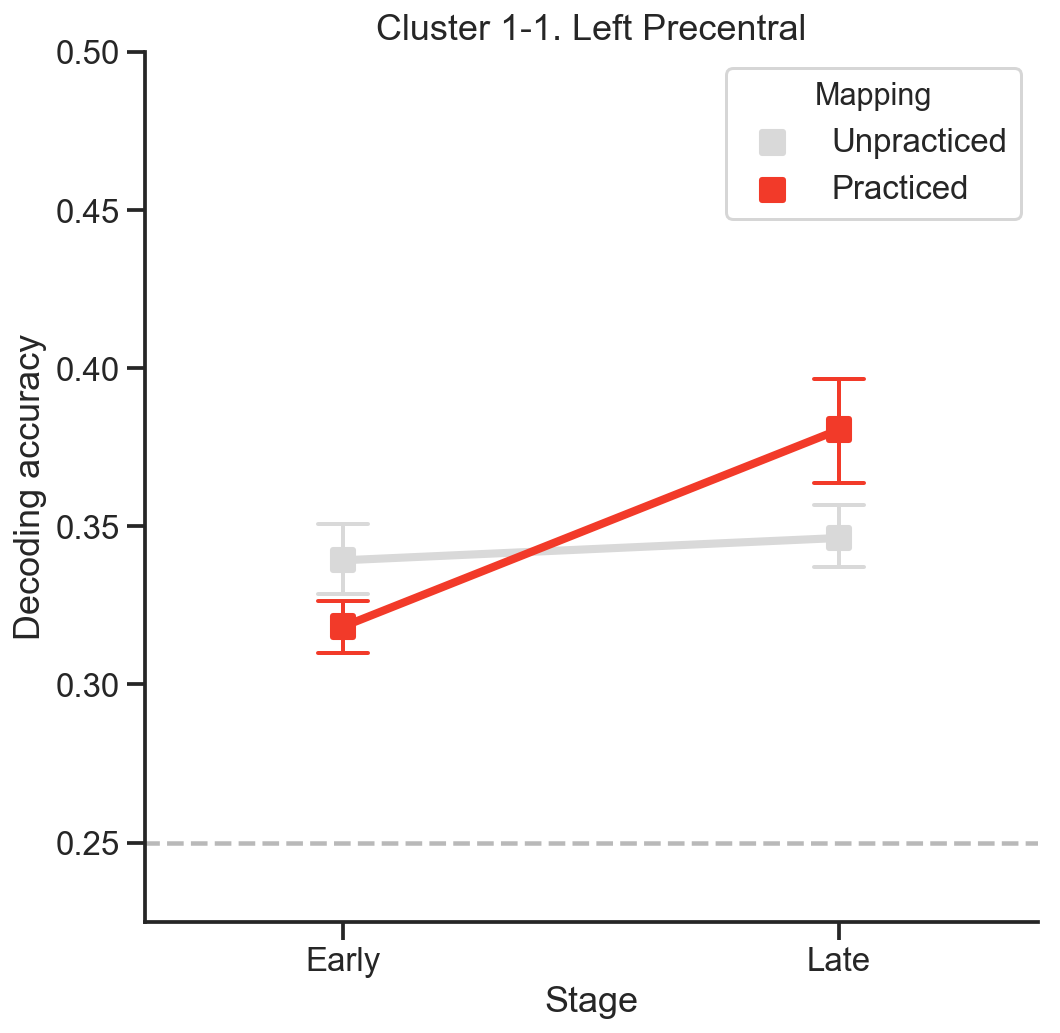

In [14]:
draw_lineplot(roi_names[0], 'Cluster 1-1. Left Precentral')

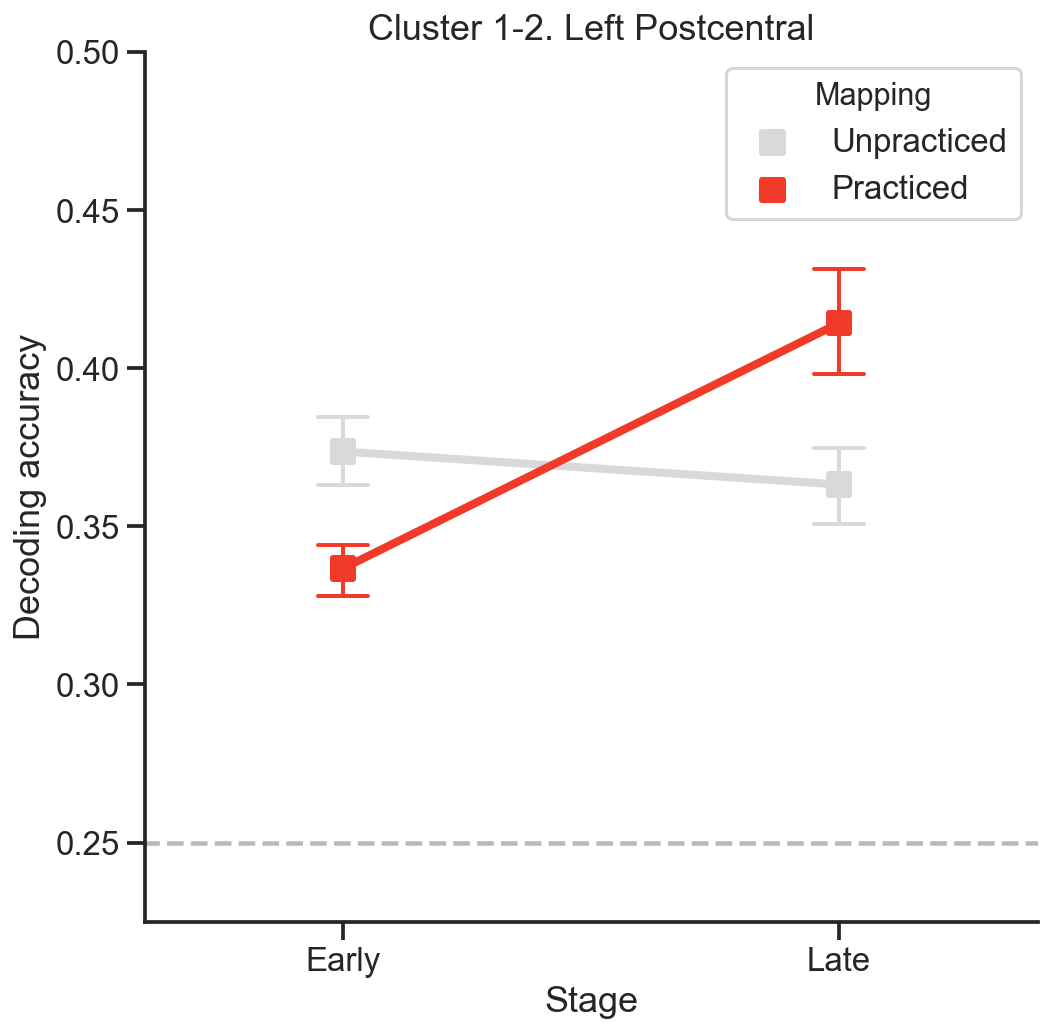

In [15]:
draw_lineplot(roi_names[1], 'Cluster 1-2. Left Postcentral')

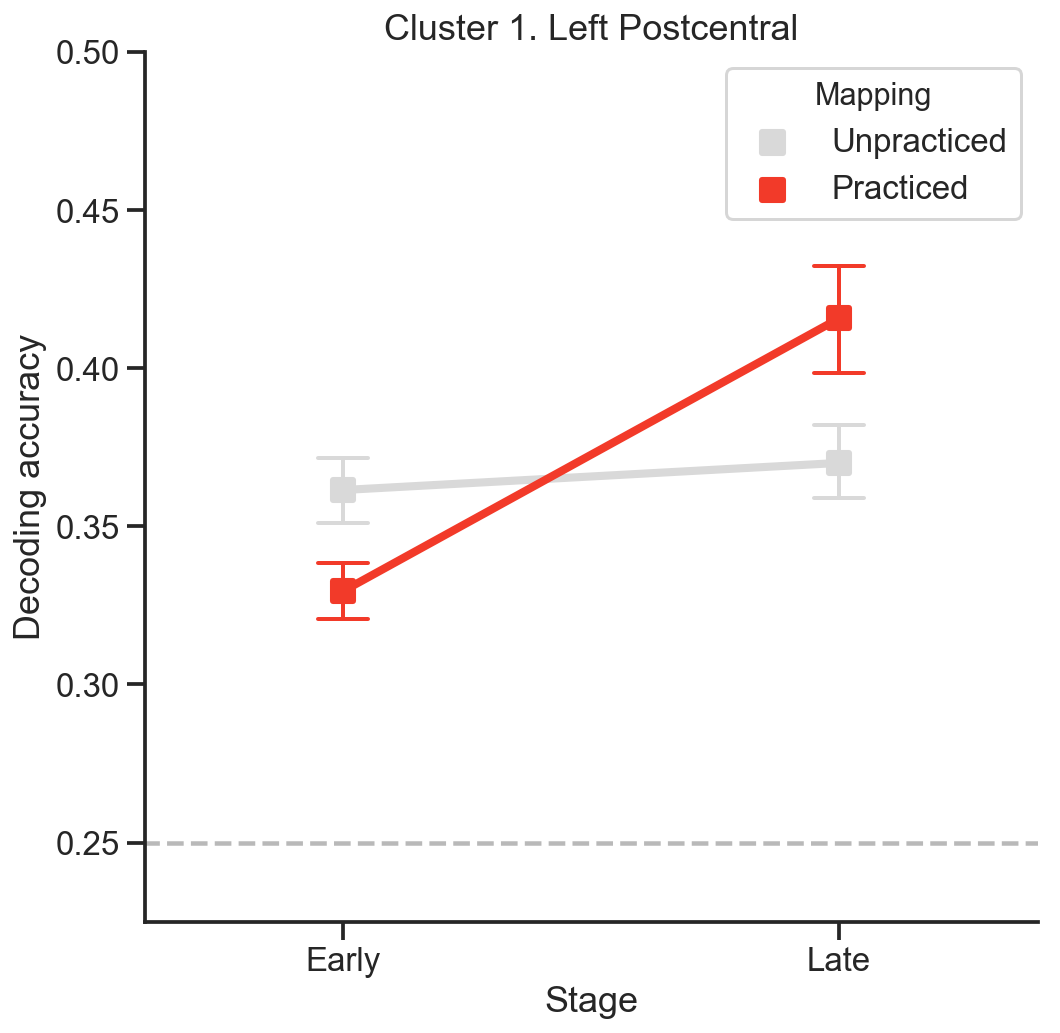

In [16]:
draw_lineplot(roi_names[2], 'Cluster 1. Left Postcentral')

In [18]:
def draw_lineplot(roi_name, title):
    plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.5)
    plt.ylabel('Decoding accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

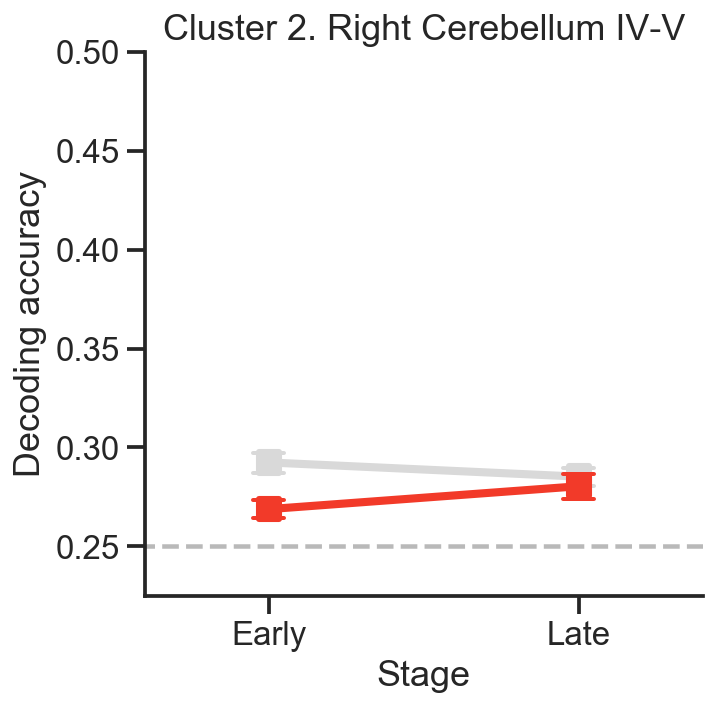

In [19]:
draw_lineplot(roi_names[3], 'Cluster 2. Right Cerebellum IV-V')

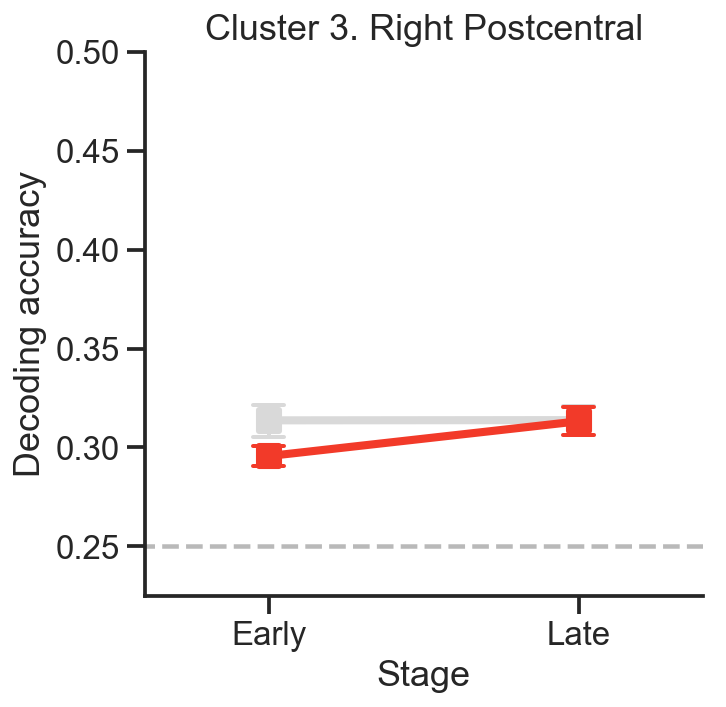

In [20]:
draw_lineplot(roi_names[4], 'Cluster 3. Right Postcentral')

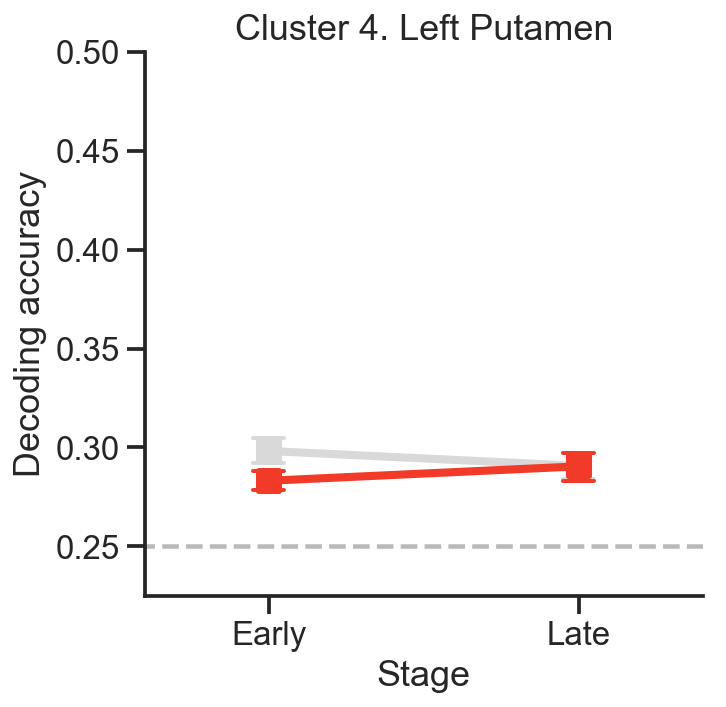

In [21]:
draw_lineplot(roi_names[5], 'Cluster 4. Left Putamen')

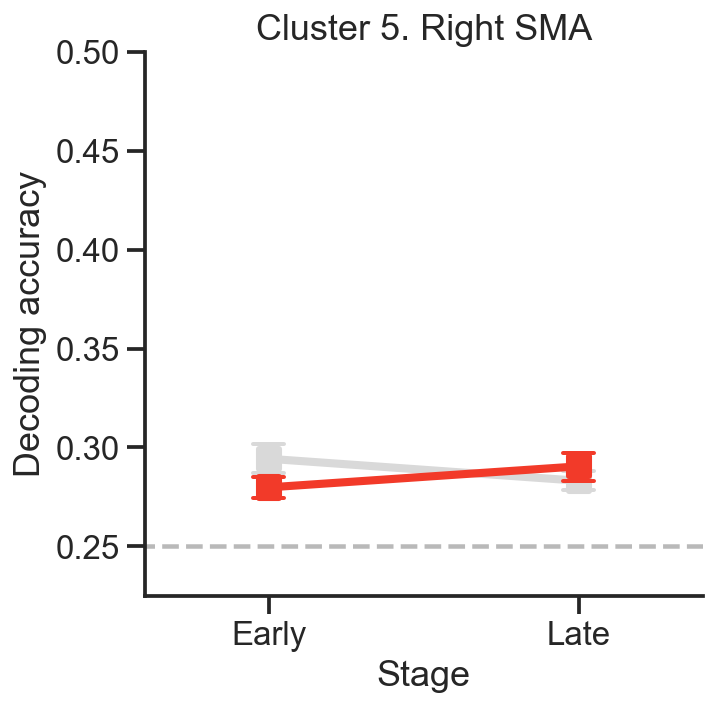

In [22]:
draw_lineplot(roi_names[6], 'Cluster 5. Right SMA')

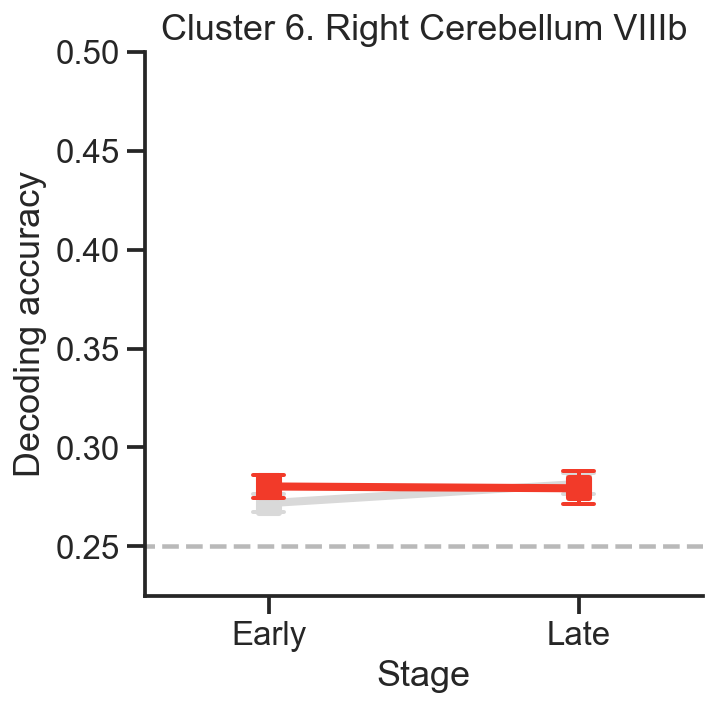

In [23]:
draw_lineplot(roi_names[7], 'Cluster 6. Right Cerebellum VIIIb')

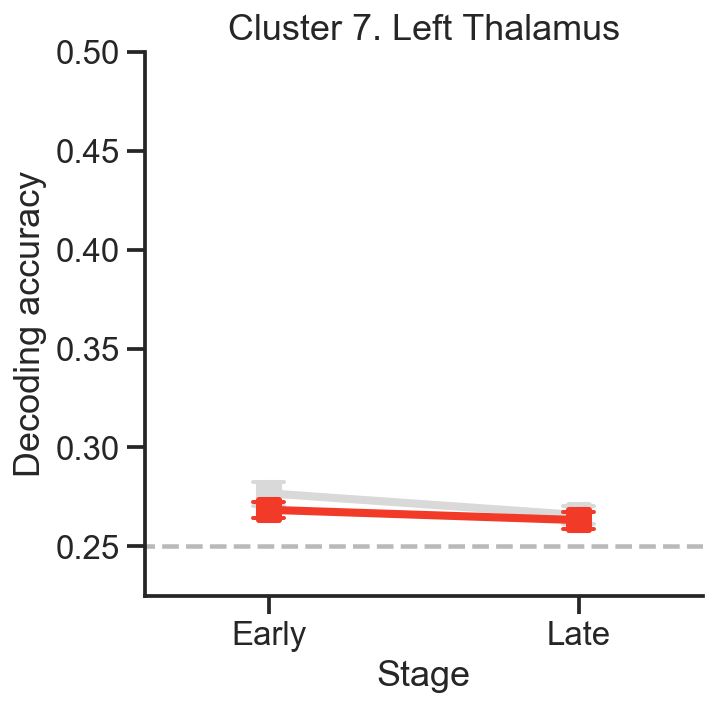

In [24]:
draw_lineplot(roi_names[8], 'Cluster 7. Left Thalamus')

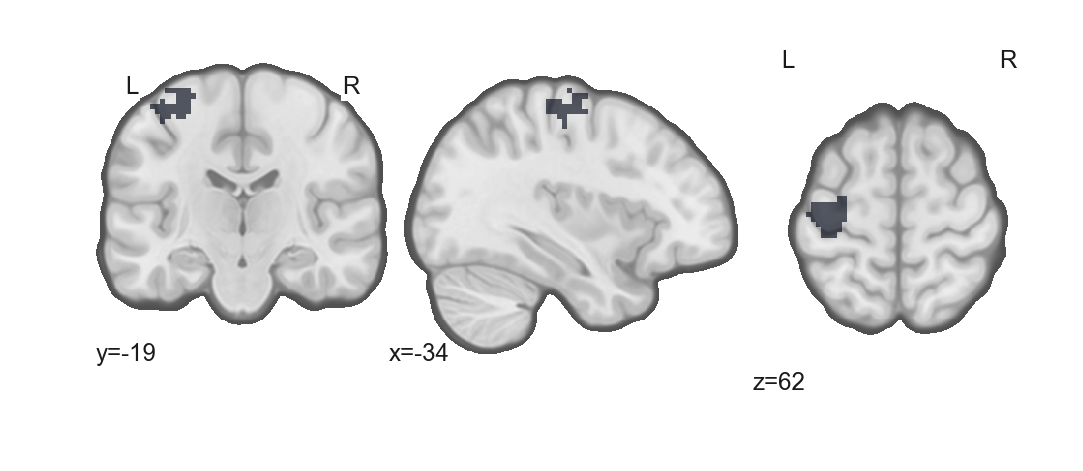

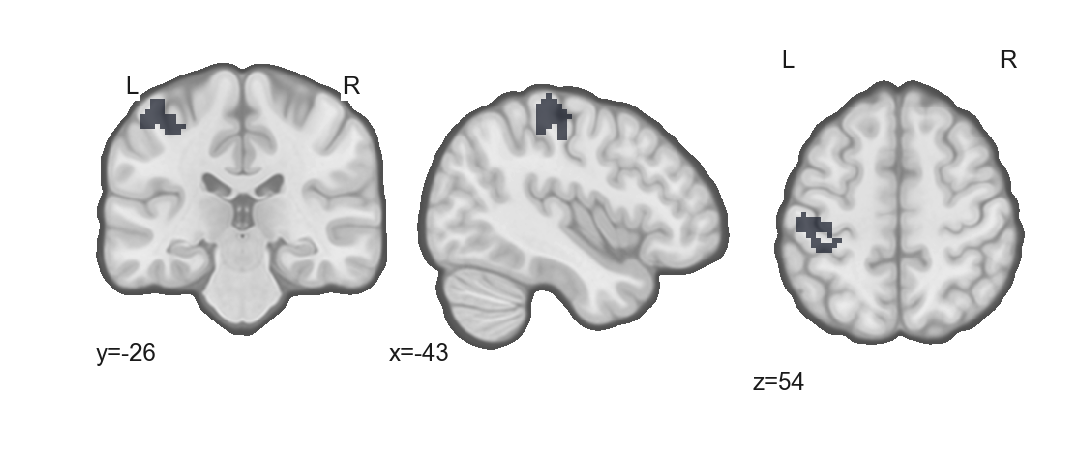

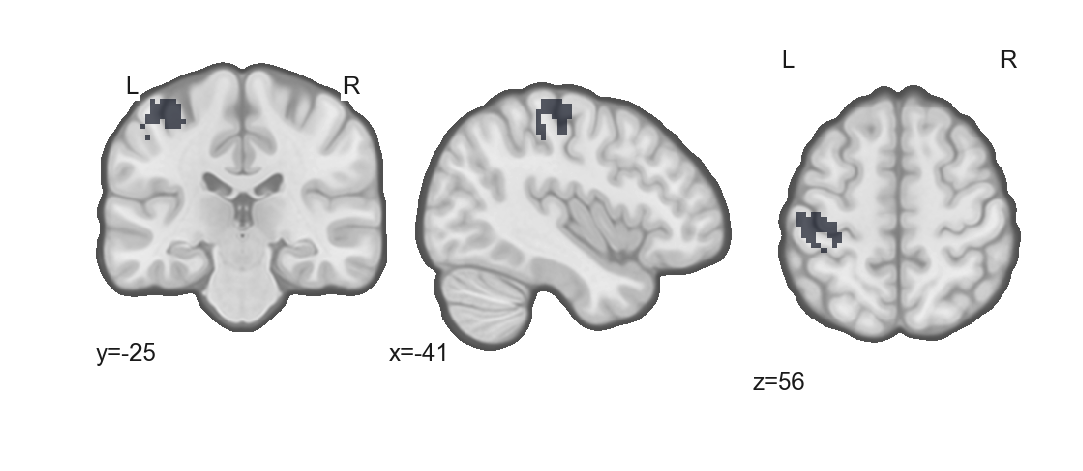

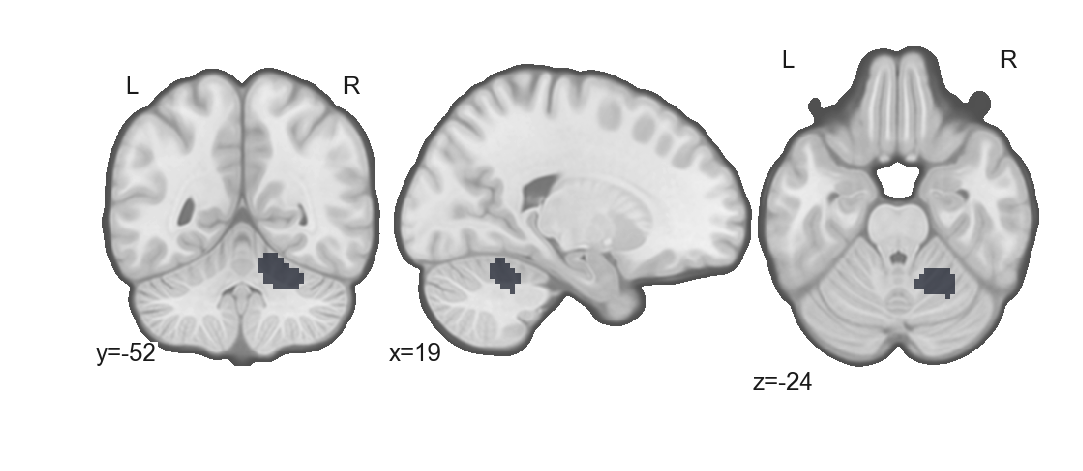

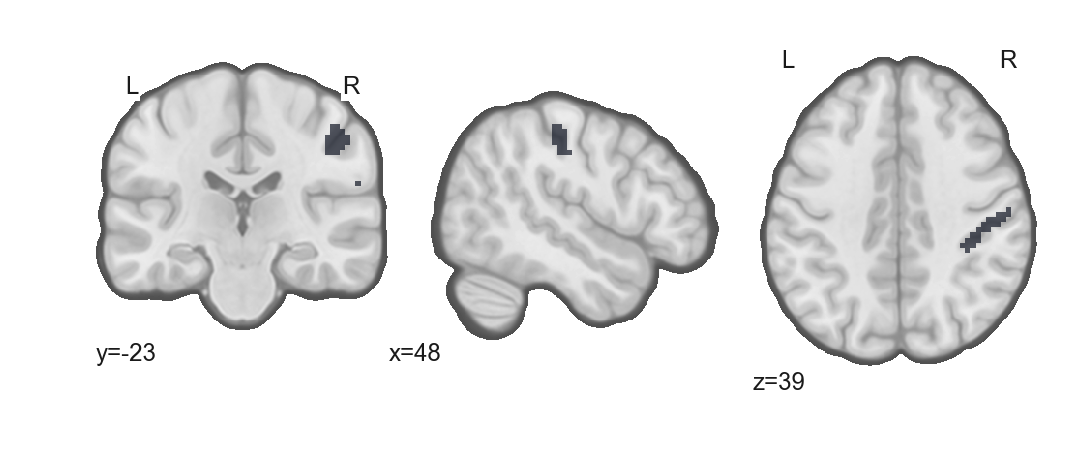

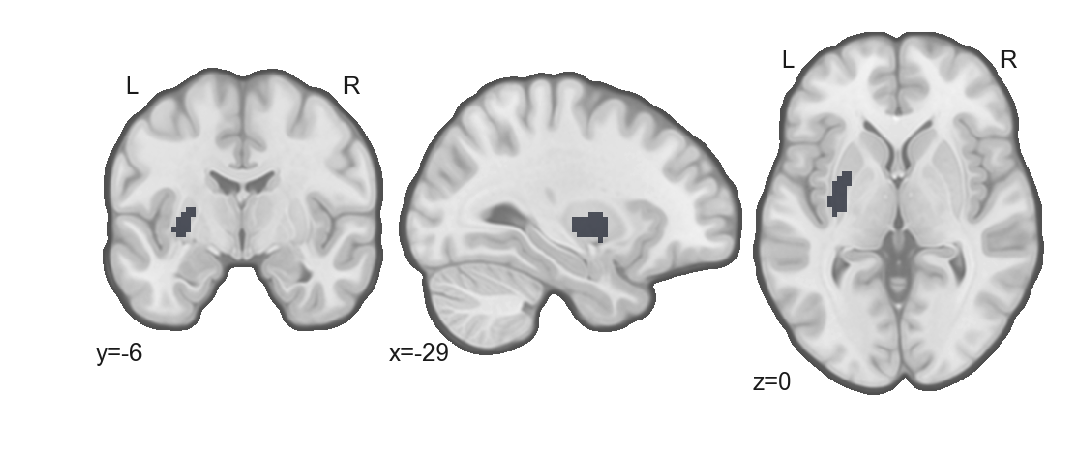

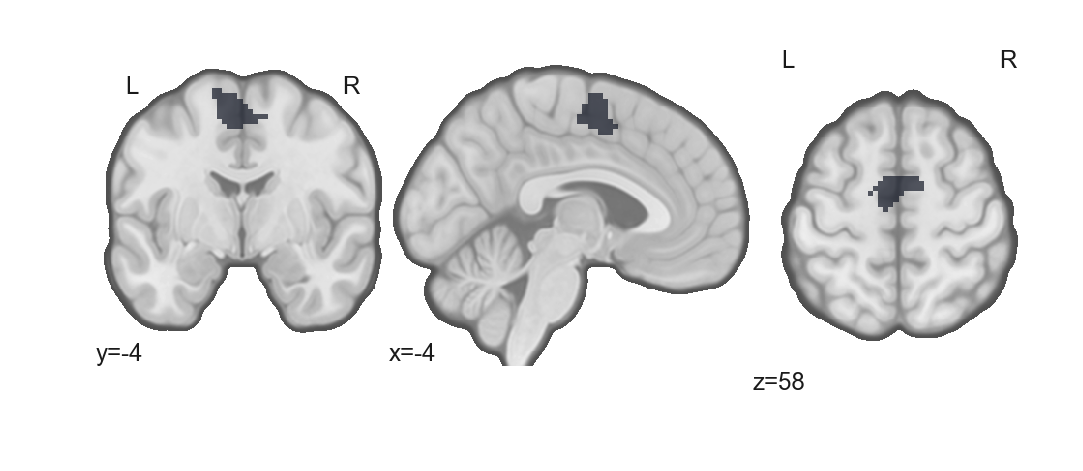

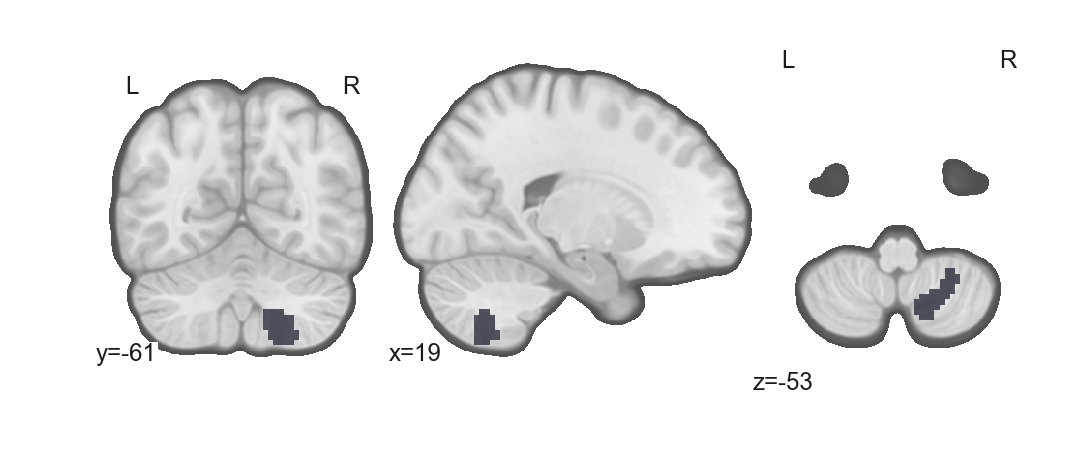

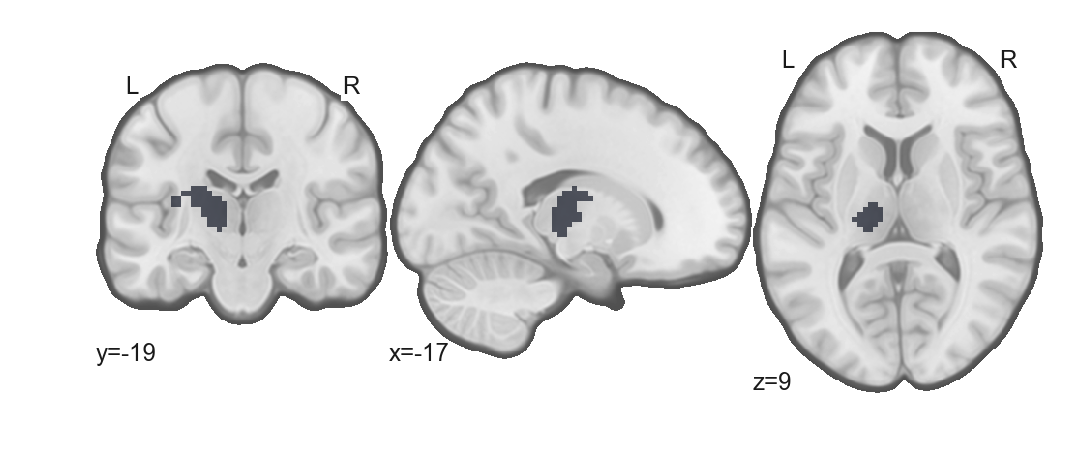

In [45]:
from matplotlib.colors import LinearSegmentedColormap

cm = LinearSegmentedColormap.from_list('GA', [(1, 1, 1), (19/255, 24/255, 38/255)], N=1)

for name in roi_names:
    fig = nilearn.plotting.plot_roi(roi_imgs[name],
                          '/Users/eyshin/Desktop/MRIcroGL/mni152_2009bet.nii.gz', 
                          draw_cross=False, black_bg=False, cmap=cm)
    fig.savefig('20200313_%s.png' % (name), dpi=300)

# DMN whole ROI Decoding accuracy

In [27]:
roi_dir = '/Volumes/clmnlab/GA/fmri_data/masks/DMN/'

module_names = ['Core', 'dMsub', 'MTLsub']

roi_imgs = []
roi_names = []

for name in module_names:
    fnames = glob.glob('%s/%s_*.nii' % (roi_dir, name))
    
    #roi_imgs[name] = {}
    
    for fname in fnames:
        roi_name = fname.replace('/Volumes/clmnlab/GA/fmri_data/masks/DMN/', '').replace('.nii', '')
        roi_imgs.append(nilearn.image.load_img(fname))
        roi_names.append(roi_name)

In [28]:
roi_names

['Core_aMPFC_r',
 'Core_aMPFC_l',
 'Core_PCC_l',
 'Core_PCC_r',
 'dMsub_TempP_l_temp',
 'dMsub_LTC_l',
 'dMsub_TPJ_r',
 'dMsub_LTC_r',
 'dMsub_TempP_r_temp',
 'dMsub_dMPFC',
 'dMsub_TPJ_l',
 'MTLsub_PHC_r',
 'MTLsub_vMPFC',
 'MTLsub_Rsp_l',
 'MTLsub_Rsp_r',
 'MTLsub_HF_l',
 'MTLsub_PHC_l',
 'MTLsub_pIPL_l',
 'MTLsub_pIPL_r',
 'MTLsub_HF_r']

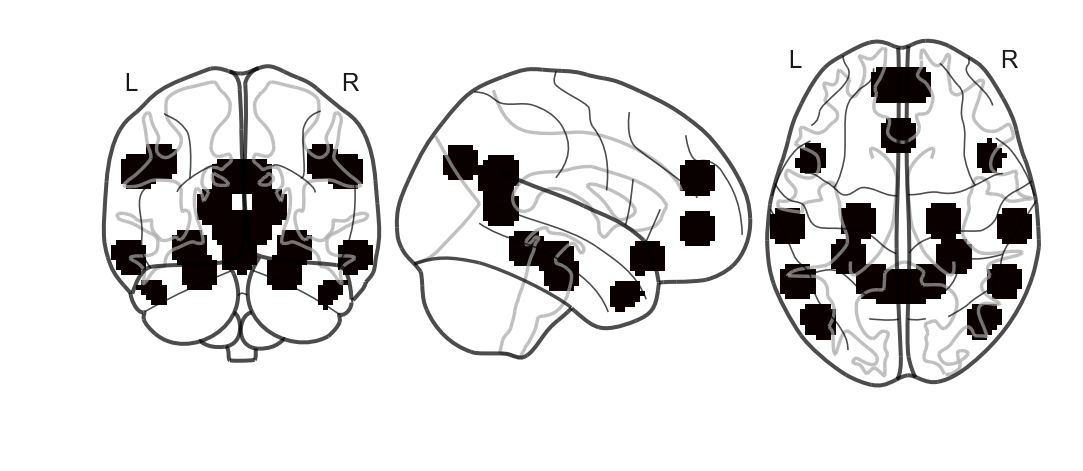

In [52]:
dmn_roi_img = nilearn.image.math_img(img1=roi_imgs[0], formula='img1 * 0')

for roi_img in roi_imgs:
    dmn_roi_img = nilearn.image.math_img(img1=dmn_roi_img, img2=roi_img, formula='img1 + img2')
    
dmn_roi_img = nilearn.image.math_img(img1=dmn_roi_img, formula='img1 > 0')
    
_ = nilearn.plotting.plot_glass_brain(dmn_roi_img)

In [55]:
results = {}

for subj in subj_list:
    for roi_img, roi_name in zip(roi_imgs, roi_names):

        X = [
            fast_masking(roi=roi_img, img=data[subj, 1]), 
            fast_masking(roi=roi_img, img=data[subj, 2]), 
            fast_masking(roi=roi_img, img=data[subj, 3]), 
        ]

        results['pos', 'practiced', subj, roi_name] = cross_validation(X, target_pos)

        X = [
            fast_masking(roi=roi_img, img=data[subj, 4]), 
            fast_masking(roi=roi_img, img=data[subj, 5]), 
            fast_masking(roi=roi_img, img=data[subj, 6]), 
        ]

        results['pos', 'unpracticed', subj, roi_name] = cross_validation(X, target_pos)

        print(subj, roi_name, end='\r')

In [56]:
with open('20200313_dmn_dec-acc.pkl', 'wb') as file:
    pickle.dump(file=file, obj=results)

In [25]:
with open('20200313_dmn_dec-acc.pkl', 'rb') as file:
    results = pickle.load(file=file)

In [29]:
wit_results = results

wit_df = pd.DataFrame(columns=['subj', 'roi_module', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name in roi_names:
        roi_module_name = roi_name.split('_')[0]
        re_roi_name = '_'.join(roi_name.split('_')[1:])
        
        wit_df = wit_df.append({'subj': subj,
                        'roi_module': roi_module_name,
                        'roi_name': re_roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_module': roi_module_name,
                        'roi_name': re_roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_module': roi_module_name,
                        'roi_name': re_roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_module': roi_module_name,
                        'roi_name': re_roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
wit_df.head()

subj roi_module roi_name      Mapping  Mean Accuracy  Stage
0  GA01       Core  aMPFC_r  Unpracticed       0.312500  Early
1  GA01       Core  aMPFC_r  Unpracticed       0.319444   Late
2  GA01       Core  aMPFC_r    Practiced       0.319444  Early
3  GA01       Core  aMPFC_r    Practiced       0.305556   Late
4  GA01       Core  aMPFC_l  Unpracticed       0.364583  Early

In [30]:
wit_df.to_csv('20200313_dmn_dec-acc.csv')

In [66]:
wit_df.tail(20)

subj roi_module roi_name      Mapping  Mean Accuracy  Stage
2380  GA44     MTLsub     HF_l  Unpracticed       0.302083  Early
2381  GA44     MTLsub     HF_l  Unpracticed       0.295139   Late
2382  GA44     MTLsub     HF_l    Practiced       0.298611  Early
2383  GA44     MTLsub     HF_l    Practiced       0.284722   Late
2384  GA44     MTLsub    PHC_l  Unpracticed       0.340278  Early
2385  GA44     MTLsub    PHC_l  Unpracticed       0.298611   Late
2386  GA44     MTLsub    PHC_l    Practiced       0.246528  Early
2387  GA44     MTLsub    PHC_l    Practiced       0.256944   Late
2388  GA44     MTLsub   pIPL_l  Unpracticed       0.274306  Early
2389  GA44     MTLsub   pIPL_l  Unpracticed       0.291667   Late
2390  GA44     MTLsub   pIPL_l    Practiced       0.246528  Early
2391  GA44     MTLsub   pIPL_l    Practiced       0.288194   Late
2392  GA44     MTLsub   pIPL_r  Unpracticed       0.350694  Early
2393  GA44     MTLsub   pIPL_r  Unpracticed       0.326389   Late
2394  GA44     MTLsub   pIPL_r    Practiced       0.315972  Early
2395  GA44     MTLsub   pIPL_r    Practiced       0.312500   Late
2396  GA44     MTLsub     HF_r  Unpracticed       0.302083  Early
2397  GA44     MTLsub     HF_r  Unpracticed       0.322917   Late
2398  GA44     MTLsub     HF_r    Practiced       0.295139  Early
2399  GA44     MTLsub     HF_r    Practiced       0.347222   Late

In [82]:
pvals, tvals = [], []

for roi_module in ['Core', 'dMsub', 'MTLsub']:
    sub_df = wit_df[(wit_df['roi_module'] == roi_module) & (wit_df['Mapping'] == 'Practiced')]
    
    sub_df = sub_df.groupby(['subj', 'roi_module', 'Mapping', 'Stage']).mean()
    sub_df.reset_index(inplace=True)
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, ['Core', 'dMsub', 'MTLsub'], pvals, tvals):
    print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

                 Core False 0.14  1.73 0.093
                dMsub False 0.12  2.15 0.040
               MTLsub False 0.81 -0.24 0.811


In [84]:
pvals, tvals = [], []

for roi_name in roi_names:
    roi_module_name = roi_name.split('_')[0]
    re_roi_name = '_'.join(roi_name.split('_')[1:])
    
    sub_df = wit_df[(wit_df['roi_name'] == re_roi_name) & (wit_df['Mapping'] == 'Practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

   dMsub_TempP_r_temp  True 0.00  4.24 0.000


In [81]:
pvals, tvals = [], []

for roi_module in ['Core', 'dMsub', 'MTLsub']:
    sub_df = wit_df[(wit_df['roi_module'] == roi_module) & (wit_df['Stage'] == 'Late')]
    
    sub_df = sub_df.groupby(['subj', 'roi_module', 'Mapping', 'Stage']).mean()
    sub_df.reset_index(inplace=True)
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, ['Core', 'dMsub', 'MTLsub'], pvals, tvals):
    print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

                 Core False 0.19 -1.91 0.067
                dMsub False 0.19 -1.58 0.124
               MTLsub False 0.51 -0.67 0.506


In [85]:
pvals, tvals = [], []

for roi_name in roi_names:
    roi_module_name = roi_name.split('_')[0]
    re_roi_name = '_'.join(roi_name.split('_')[1:])
    
    sub_df = wit_df[(wit_df['roi_name'] == re_roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

In [31]:
def draw_avg_lineplot(roi_module, title):
    plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_module'] == roi_module]
    
    sub_df = sub_df.groupby(['subj', 'roi_module', 'Mapping', 'Stage']).mean()
    sub_df.reset_index(inplace=True)
    
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.3)
    plt.ylabel('Decoding accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

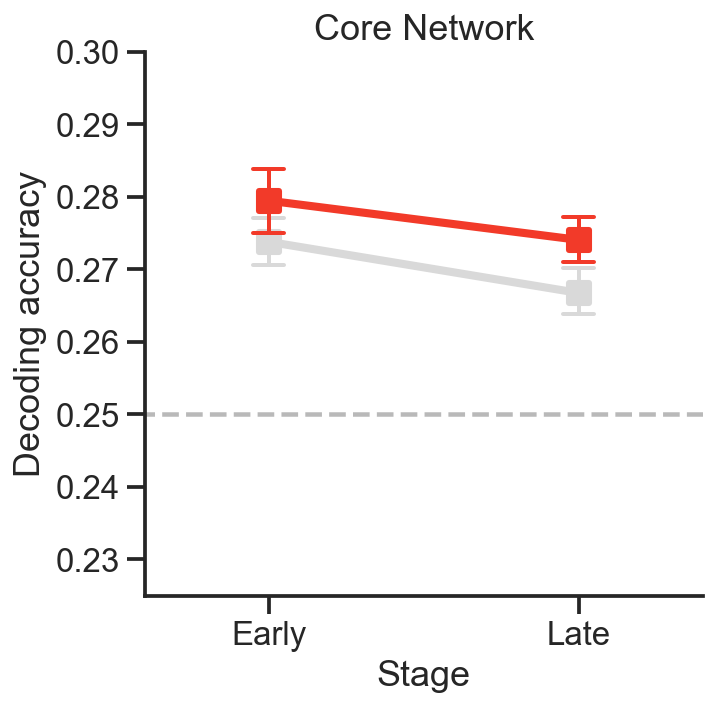

In [32]:
draw_avg_lineplot('Core', 'Core Network')

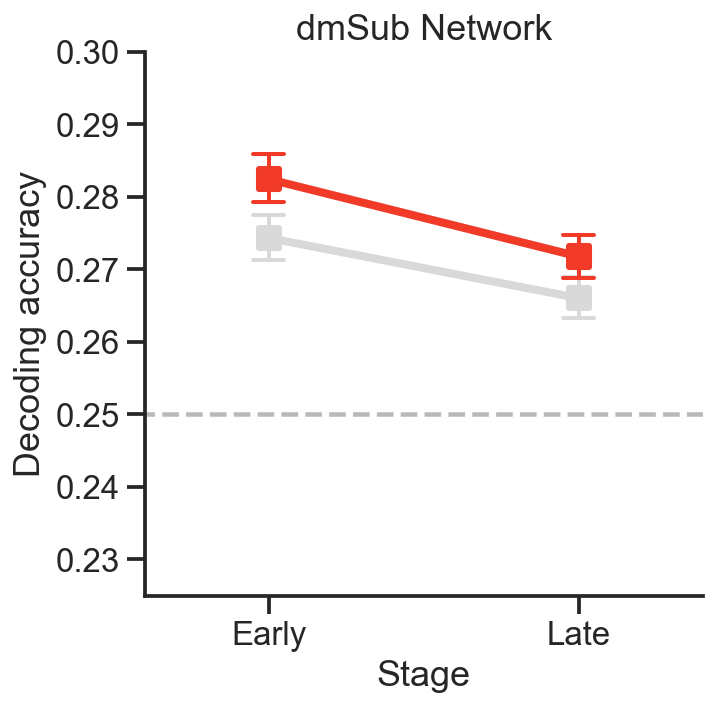

In [33]:
draw_avg_lineplot('dMsub', 'dmSub Network')

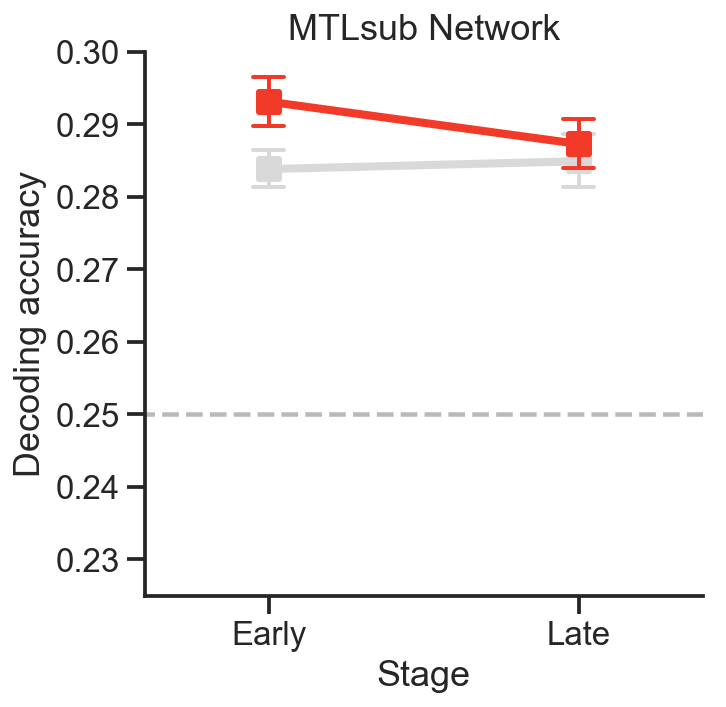

In [34]:
draw_avg_lineplot('MTLsub', 'MTLsub Network')

# DMN acc by module

In [78]:
roi_dir = '/Volumes/clmnlab/GA/fmri_data/masks/DMN/'

module_names = ['Core', 'dMsub', 'MTLsub']

roi_imgs = []
roi_names = []

for name in module_names:
    fname = roi_dir + name + '.nii'
    roi_imgs.append(nilearn.image.load_img(fname))
    roi_names.append(name)

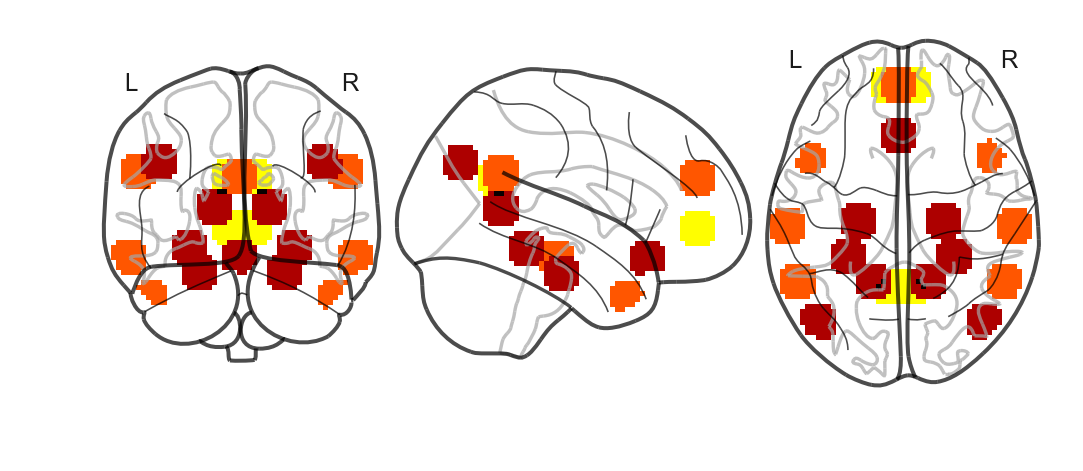

In [89]:
dmn_roi_img = nilearn.image.math_img(img1=roi_imgs[0], formula='img1 * 0')

for i, roi_img in enumerate(roi_imgs, 1):
    dmn_roi_img = nilearn.image.math_img(img1=dmn_roi_img, img2=roi_img, formula='img1 + img2 * %d' % i)
    
_ = nilearn.plotting.plot_glass_brain(dmn_roi_img)

In [90]:
results = {}

for subj in subj_list:
    for roi_img, roi_name in zip(roi_imgs, roi_names):

        X = [
            fast_masking(roi=roi_img, img=data[subj, 1]), 
            fast_masking(roi=roi_img, img=data[subj, 2]), 
            fast_masking(roi=roi_img, img=data[subj, 3]), 
        ]

        results['pos', 'practiced', subj, roi_name] = cross_validation(X, target_pos)

        X = [
            fast_masking(roi=roi_img, img=data[subj, 4]), 
            fast_masking(roi=roi_img, img=data[subj, 5]), 
            fast_masking(roi=roi_img, img=data[subj, 6]), 
        ]

        results['pos', 'unpracticed', subj, roi_name] = cross_validation(X, target_pos)

        print(subj, roi_name, end='\r')

In [91]:
with open('20200317_dmn_module_dec-acc.pkl', 'wb') as file:
    pickle.dump(file=file, obj=results)

In [76]:
with open('20200317_dmn_module_dec-acc.pkl', 'rb') as file:
    results = pickle.load(file=file)

In [79]:
wit_results = results

wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name in roi_names:        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
wit_df.head()

subj roi_name      Mapping  Mean Accuracy  Stage
0  GA01     Core  Unpracticed       0.305556  Early
1  GA01     Core  Unpracticed       0.302083   Late
2  GA01     Core    Practiced       0.350694  Early
3  GA01     Core    Practiced       0.298611   Late
4  GA01    dMsub  Unpracticed       0.281250  Early

In [93]:
wit_df.to_csv('20200317_dmn_module_dec-acc.csv')

In [94]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Mapping'] == 'Practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

                 Core  True 0.01  3.05 0.005
                dMsub False 0.06  2.14 0.041


In [95]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

                dMsub  True 0.01 -3.09 0.004


In [84]:
def draw_lineplot(roi_name, title):
    fig = plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.375)
    plt.yticks([0.25, 0.3, 0.35])
    plt.ylabel('Decoding accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)
    
    return fig

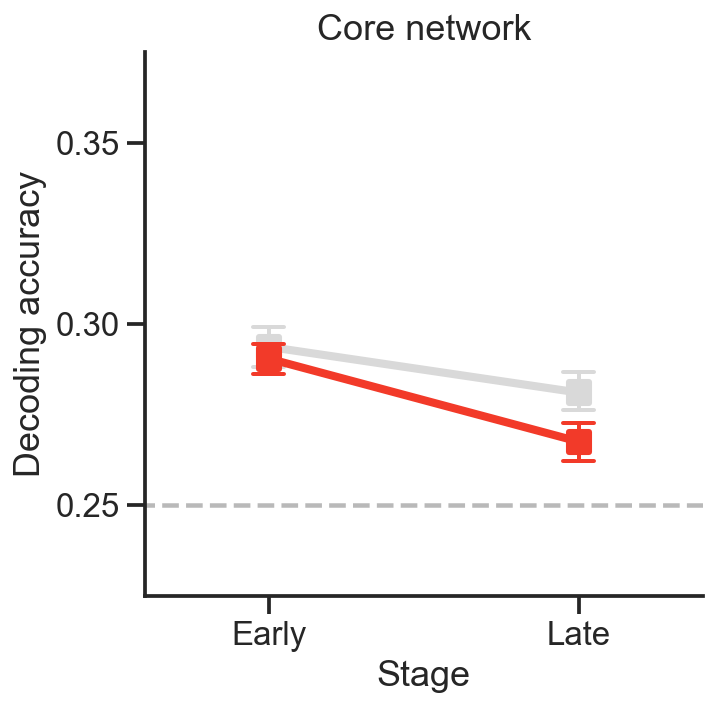

In [85]:
fig = draw_lineplot(roi_names[0], 'Core network')
fig.savefig('/Users/eyshin/Desktop/20200317_Core-module_dec-acc.png', dpi=300, bbox_inches='tight')

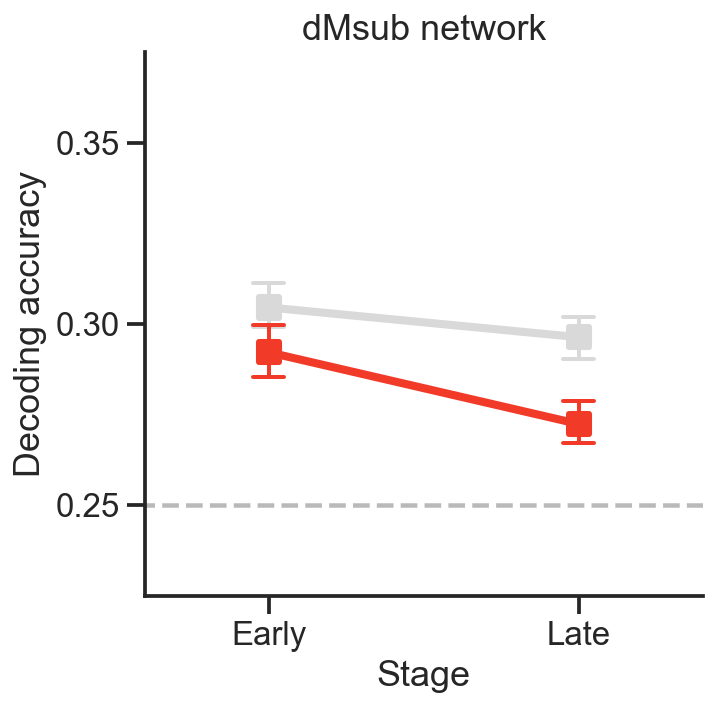

In [86]:
fig = draw_lineplot(roi_names[1], 'dMsub network')
fig.savefig('/Users/eyshin/Desktop/20200317_dMsub-module_dec-acc.png', dpi=300, bbox_inches='tight')

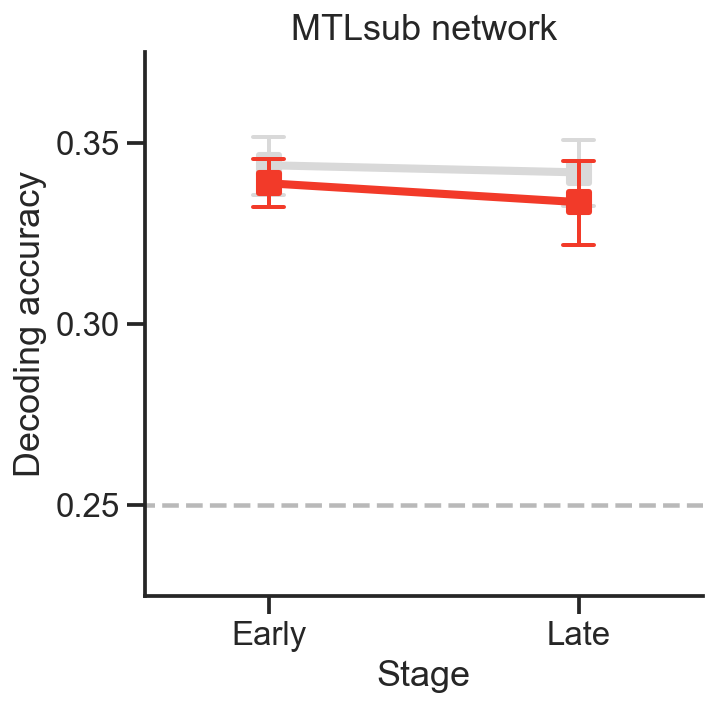

In [87]:
fig = draw_lineplot(roi_names[2], 'MTLsub network')
fig.savefig('/Users/eyshin/Desktop/20200317_MTLsub-module_dec-acc.png', dpi=300, bbox_inches='tight')

In [99]:
def draw_lineplot(roi_name, title):
    fig = plt.figure(figsize=(3, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.25, 0.3)
    plt.yticks([0.25, 0.275, 0.3])
    plt.ylabel('Decoding accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)
    
    return fig

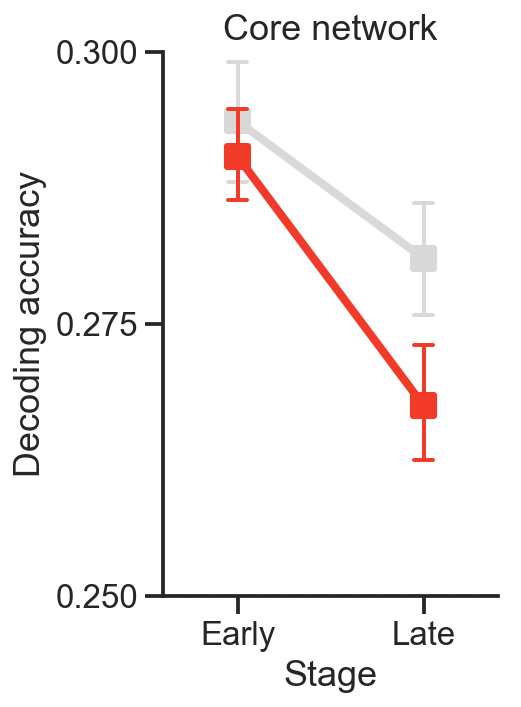

In [100]:
fig = draw_lineplot(roi_names[0], 'Core network')

# Visual areas

In [62]:
roi_info = pd.read_csv('/Volumes/clmnlab/GA/fmri_data/masks/Fan/20190926/fan_cluster_net_20191010.csv')
roi_info.head()

Unnamed: 0  label     region subregion_name             name  \
0           0      1  SFG_L_7_1            A8m   SFG_L_7_1 (8m)   
1           1      2  SFG_R_7_1            A8m   SFG_R_7_1 (8m)   
2           2      3  SFG_L_7_2           A8dl  SFG_L_7_2 (8dl)   
3           3      4  SFG_R_7_2           A8dl  SFG_R_7_2 (8dl)   
4           4      5  SFG_L_7_3            A9l   SFG_L_7_3 (9l)   

                                        full_name           lobe  \
0        Lt. superior frontal gyrus (BA8, medial)  Frontal Lobe    
1        Rt. superior frontal gyrus (BA8, medial)  Frontal Lobe    
2  Lt. superior frontal gyrus (BA8, dorsolateral)  Frontal Lobe    
3  Rt. superior frontal gyrus (BA8, dorsolateral)  Frontal Lobe    
4       Lt. superior frontal gyrus (BA9, lateral)  Frontal Lobe    

                           gyrus               descriptions mni_coordinate  \
0  SFG, Superior Frontal Gyrus           A8m, medial area 8    -5 ,15, 54    
1  SFG, Superior Frontal Gyrus           A8m, medial area 8     7, 16, 54    
2  SFG, Superior Frontal Gyrus    A8dl, dorsolateral area 8   -18, 24, 53    
3  SFG, Superior Frontal Gyrus    A8dl, dorsolateral area 8    22, 26, 51    
4  SFG, Superior Frontal Gyrus          A9l, lateral area 9   -11, 49, 40    

  laterality  yeo_7network  yeo_17network yeo_network_name  
0       left             6             17   Frontoparietal  
1      right             4              8       vAttention  
2       left             7             16          Default  
3      right             6             13   Frontoparietal  
4       left             7             17          Default

In [101]:
roi_imgs = []
roi_names = []

for _, row in roi_info.iterrows():
    if row['yeo_17network'] == 1:
        roi_imgs.append(nilearn.image.load_img('/Volumes/clmnlab/GA/fmri_data/masks/Fan/Fan280/fan.roi.resam.%.3d.nii' % (row['label'])))
        roi_names.append(row['name'])

In [119]:
results = {}

for subj in subj_list:
    for roi_img, roi_name in zip(roi_imgs, roi_names):

        X = [
            fast_masking(roi=roi_img, img=data[subj, 1]), 
            fast_masking(roi=roi_img, img=data[subj, 2]), 
            fast_masking(roi=roi_img, img=data[subj, 3]), 
        ]

        results['pos', 'practiced', subj, roi_name] = cross_validation(X, target_pos)

        X = [
            fast_masking(roi=roi_img, img=data[subj, 4]), 
            fast_masking(roi=roi_img, img=data[subj, 5]), 
            fast_masking(roi=roi_img, img=data[subj, 6]), 
        ]

        results['pos', 'unpracticed', subj, roi_name] = cross_validation(X, target_pos)

        print(subj, roi_name, end='\r')

In [120]:
with open('20200317_visual_dec-acc.pkl', 'wb') as file:
    pickle.dump(file=file, obj=results)

In [102]:
with open('20200317_visual_dec-acc.pkl', 'rb') as file:
    results = pickle.load(file=file)

In [124]:
# roi size check

roi_sizes = []

for roi_img, roi_name in zip(roi_imgs, roi_names):
    roi_sizes.append(np.sum(roi_img.get_data()))
    print(roi_name, '%d'%roi_sizes[-1])

FuG_L_3_2 (37mv) 333
FuG_R_3_2 (37mv) 297
MVOcC_L_5_1 (cLinG) 200
MVOcC_R_5_1 (cLinG) 244
MVOcC_L_5_3 (cCunG) 274
MVOcC_R_5_3 (cCunG) 216
MVOcC_R_5_4 (rLinG) 358
LOcC_L_4_1 (mOccG) 320
LOcC_R_4_1 (mOccG) 333
LOcC_L_4_3 (OPC) 416
LOcC_R_4_3 (OPC) 436
LOcC_L_4_4 (iOccG) 426
LOcC_R_4_4 (iOccG) 359
LOcC_L_2_2 (lsOccG) 251


In [125]:
np.mean(roi_sizes), np.std(roi_sizes)

(318.7857, 73.479034)

In [103]:
wit_results = results

wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

for subj in subj_list[:30]:
    for roi_name in roi_names:        
        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Unpracticed',
                        'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_name]),
                        'Stage': 'Early'}, ignore_index=True)

        wit_df = wit_df.append({'subj': subj,
                        'roi_name': roi_name,
                        'Mapping': 'Practiced',
                        'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                        'Stage': 'Late'}, ignore_index=True)
        
wit_df.head()

subj          roi_name      Mapping  Mean Accuracy  Stage
0  GA01  FuG_L_3_2 (37mv)  Unpracticed       0.406250  Early
1  GA01  FuG_L_3_2 (37mv)  Unpracticed       0.430556   Late
2  GA01  FuG_L_3_2 (37mv)    Practiced       0.493056  Early
3  GA01  FuG_L_3_2 (37mv)    Practiced       0.375000   Late
4  GA01  FuG_R_3_2 (37mv)  Unpracticed       0.312500  Early

In [126]:
wit_df.to_csv('20200317_visual_dec-acc.csv')

In [127]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Mapping'] == 'Practiced')]
    
    early_mean_accs = sub_df[sub_df['Stage'] == 'Early']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Stage'] == 'Late']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

  MVOcC_L_5_1 (cLinG)  True 0.04 -2.94 0.006
  MVOcC_R_5_1 (cLinG)  True 0.04 -2.76 0.010
  MVOcC_L_5_3 (cCunG)  True 0.04 -2.84 0.008
  MVOcC_R_5_3 (cCunG)  True 0.04 -2.65 0.013
  MVOcC_R_5_4 (rLinG) False 0.09 -2.15 0.040
     LOcC_R_4_3 (OPC) False 0.09 -2.09 0.046
   LOcC_L_4_4 (iOccG) False 0.06 -2.46 0.020
   LOcC_R_4_4 (iOccG) False 0.09 -2.06 0.049


In [128]:
pvals, tvals = [], []

for roi_name in roi_names:
    sub_df = wit_df[(wit_df['roi_name'] == roi_name) & (wit_df['Stage'] == 'Late')]
    
    early_mean_accs = sub_df[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
    late_mean_accs = sub_df[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']
    
    res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)
    pvals.append(res.pvalue)
    tvals.append(res.statistic)

res = statsmodels.stats.multitest.fdrcorrection(pvals)

for t, p, roi_name, uncorrected_p, tval in zip(*res, roi_names, pvals, tvals):
    if uncorrected_p < 0.05:
        print('%21s'%roi_name, '%5s'%t, '%.2f'%p, '%5.2f'%tval, '%.3f'%uncorrected_p)

  MVOcC_L_5_3 (cCunG) False 0.14  2.37 0.025
     LOcC_L_4_3 (OPC) False 0.14  2.26 0.031


In [66]:
sns.set(style="ticks", context='talk')

def draw_lineplot(roi_name, title):
    fig = plt.figure(figsize=(5, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.8)
    plt.ylabel('Decoding accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)
    
    return fig

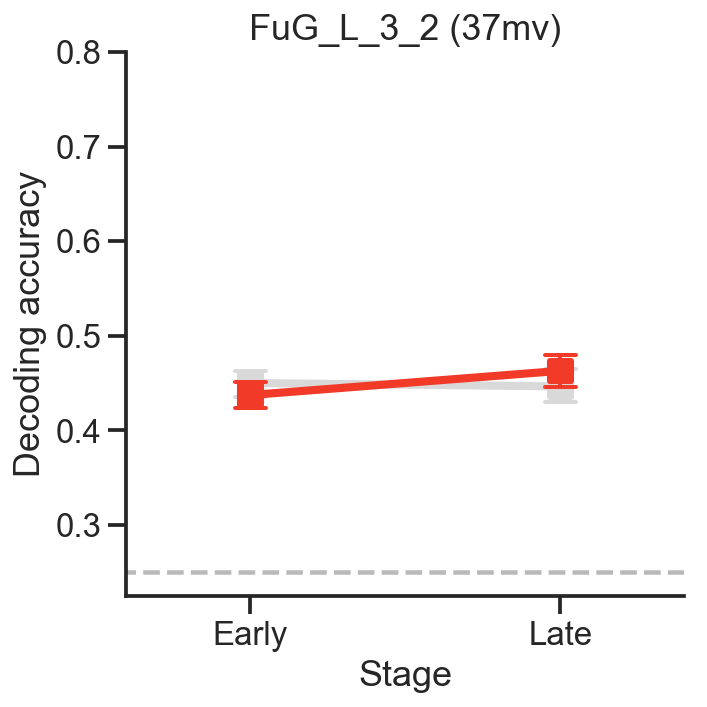

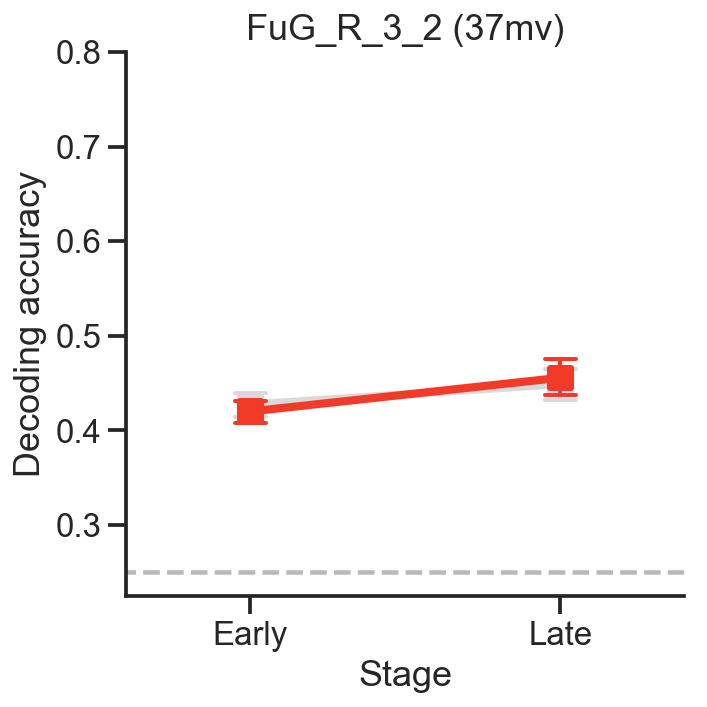

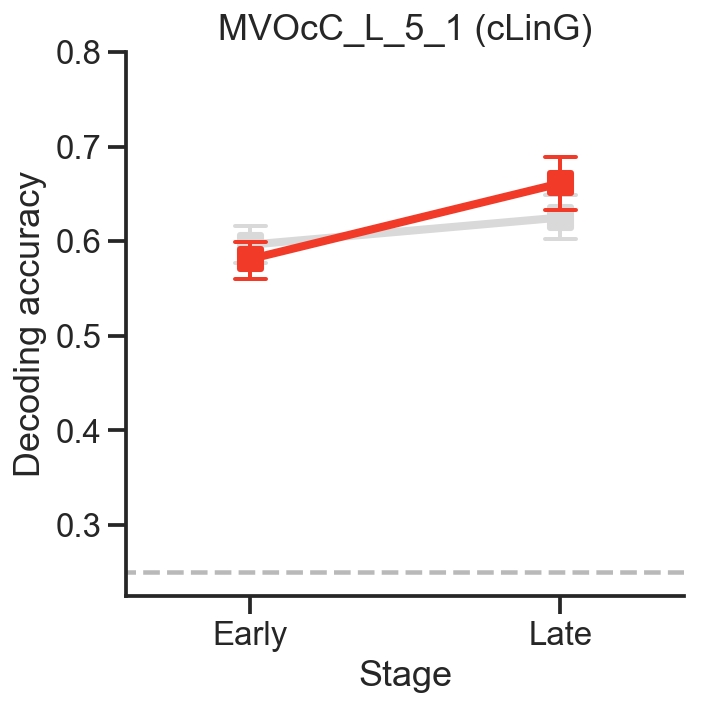

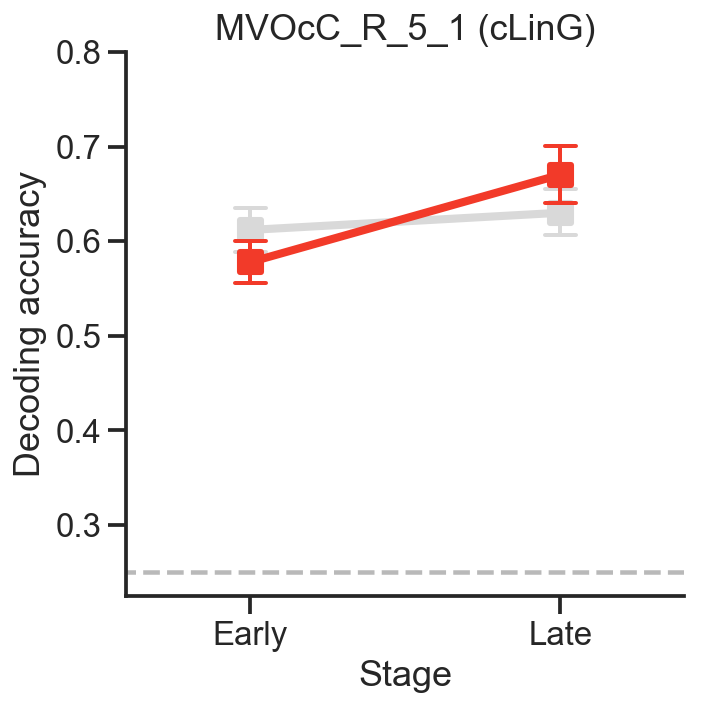

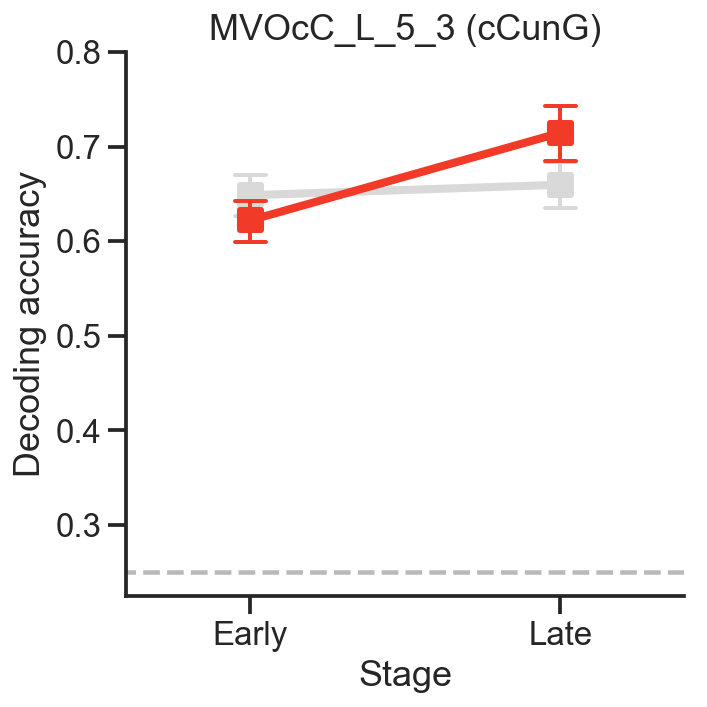

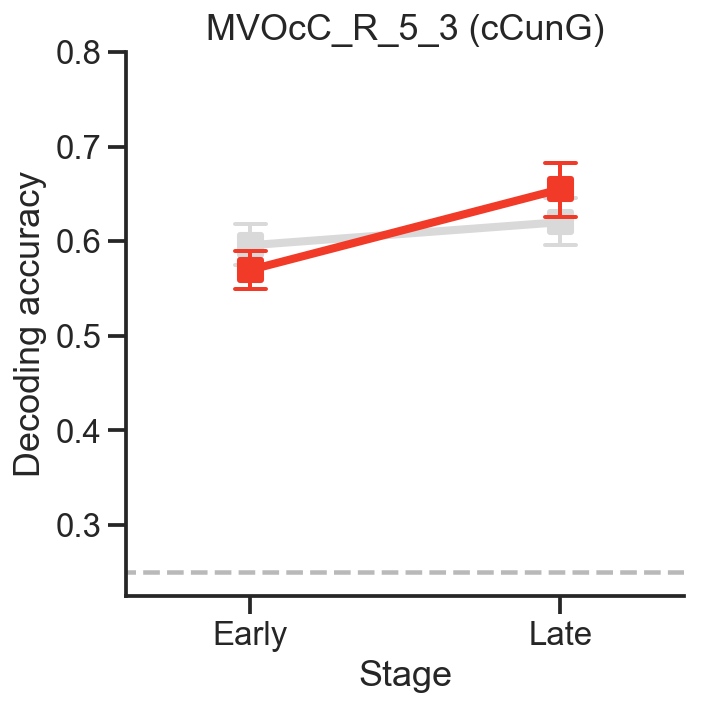

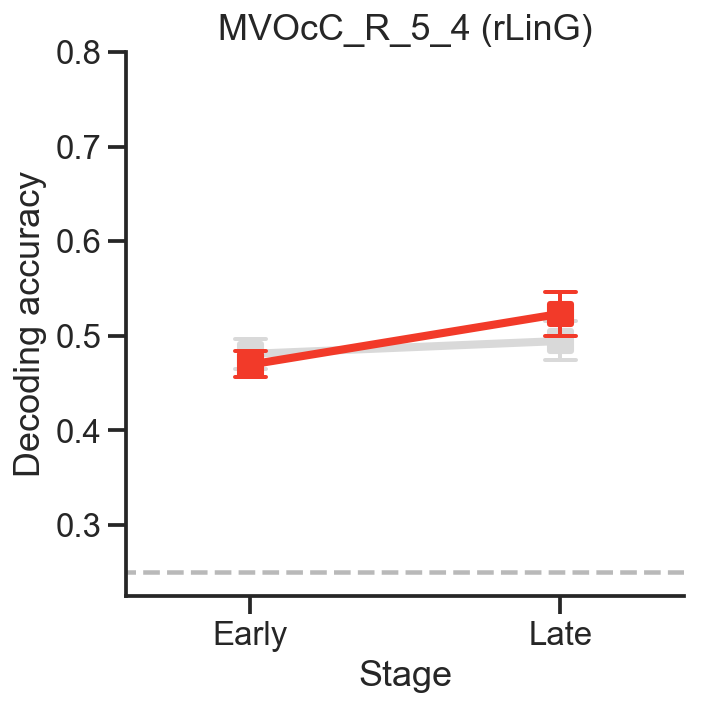

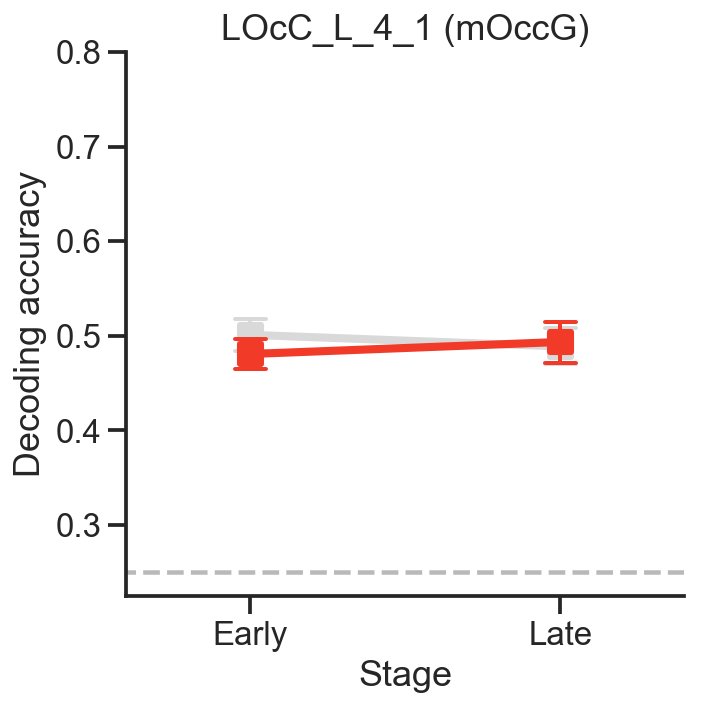

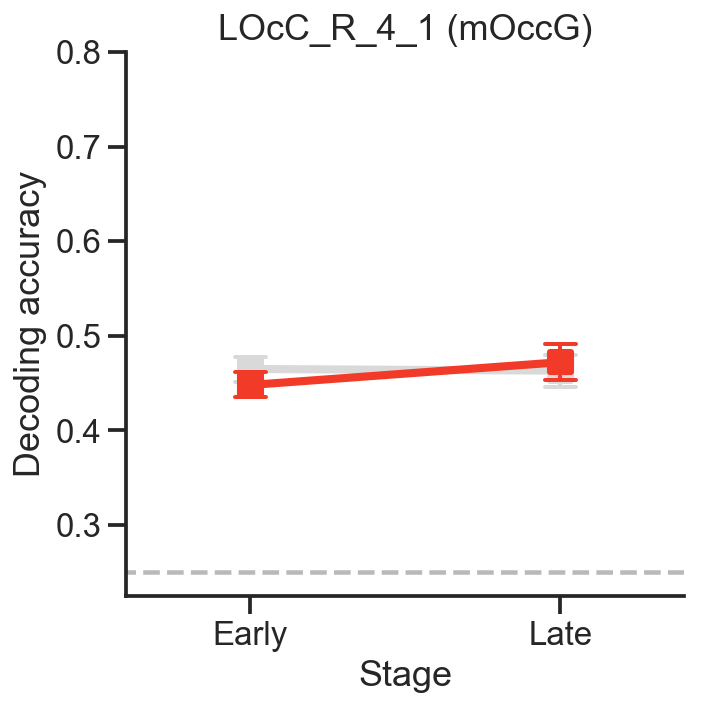

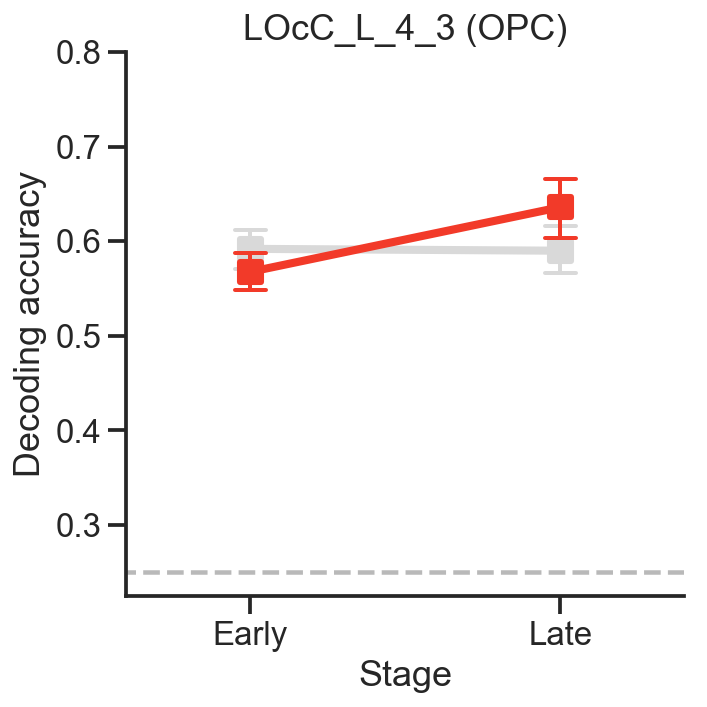

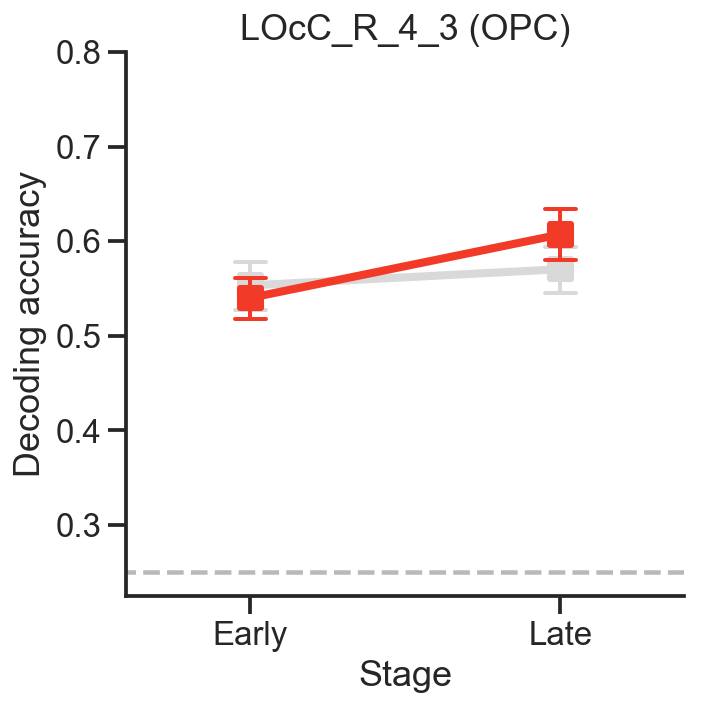

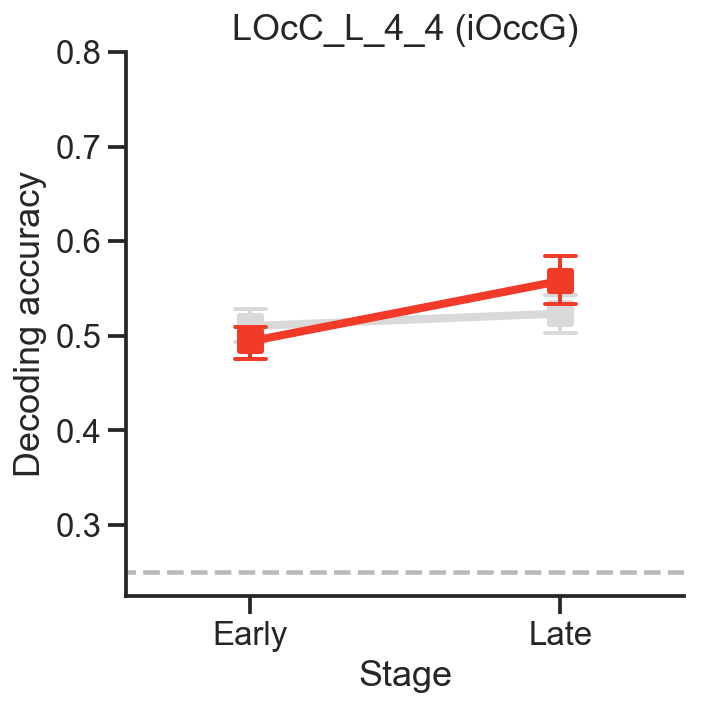

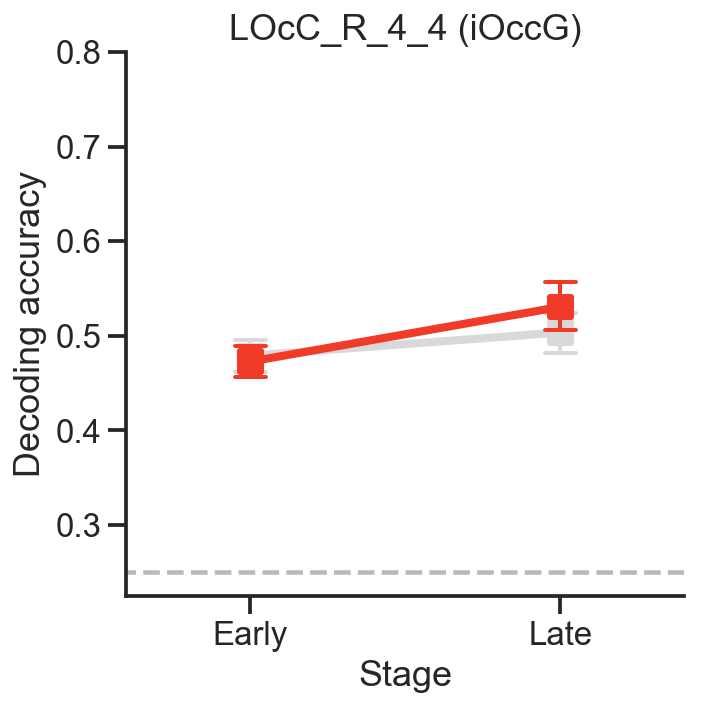

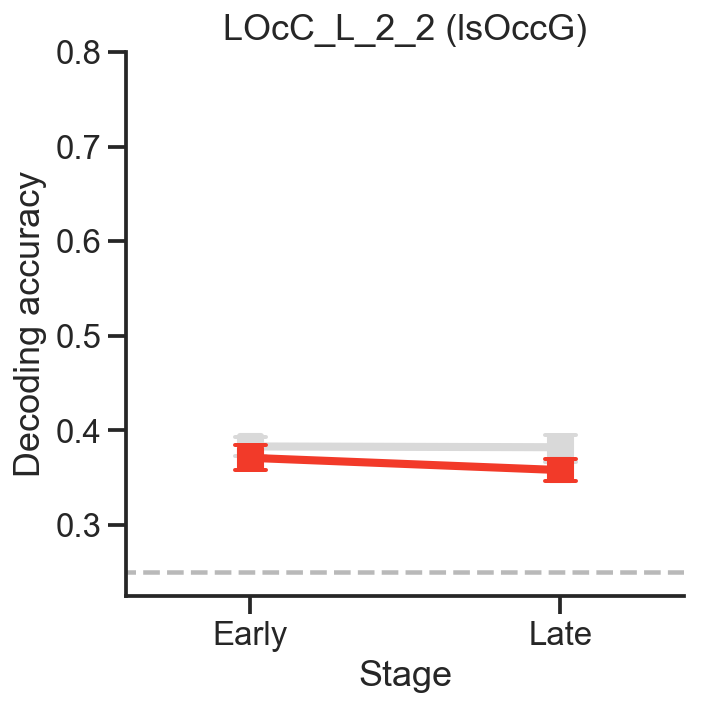

In [67]:
for name in roi_names:
    fig = draw_lineplot(name, name)
    fig.savefig('/Users/eyshin/Desktop/20200317_%s_dec-acc.png' % (name), dpi=300, bbox_inches='tight')

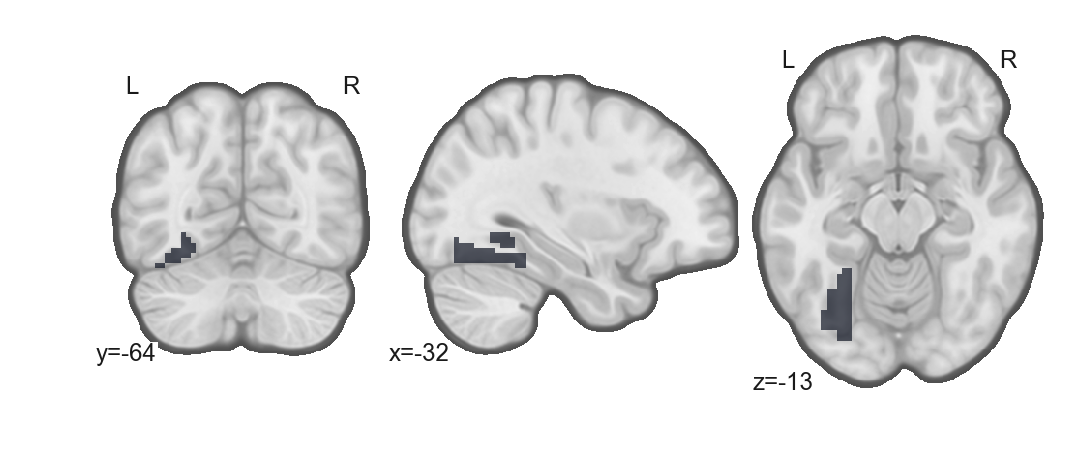

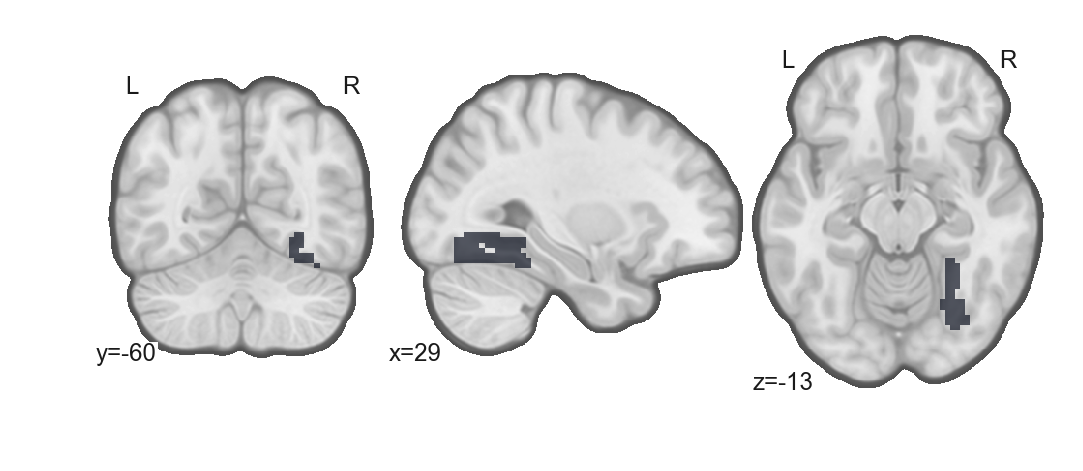

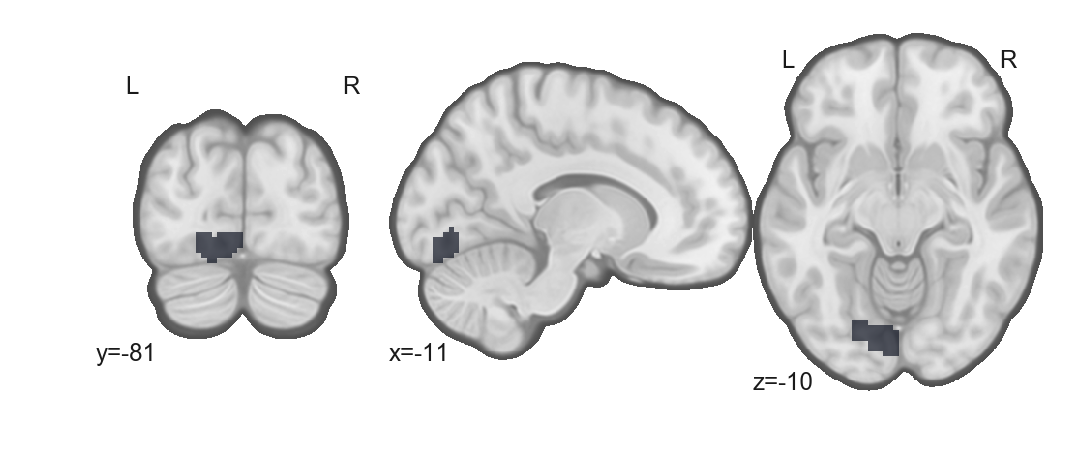

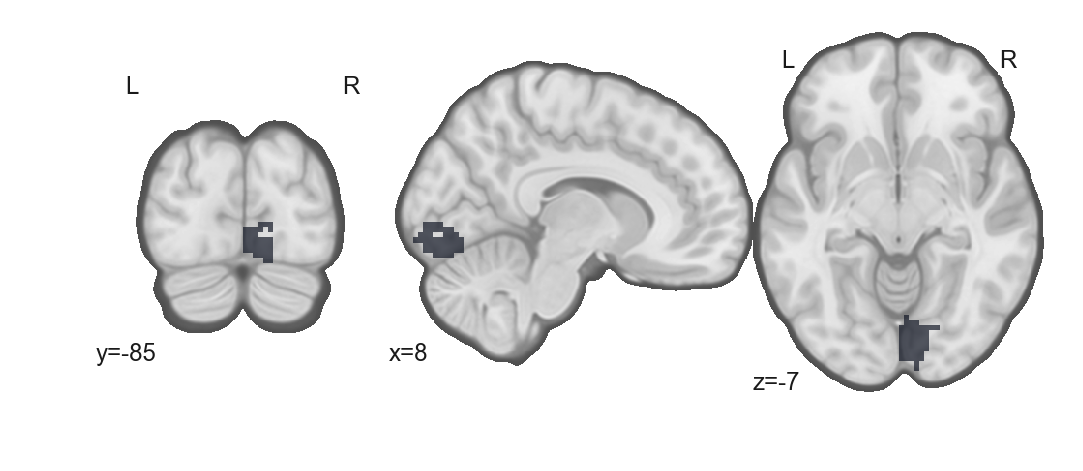

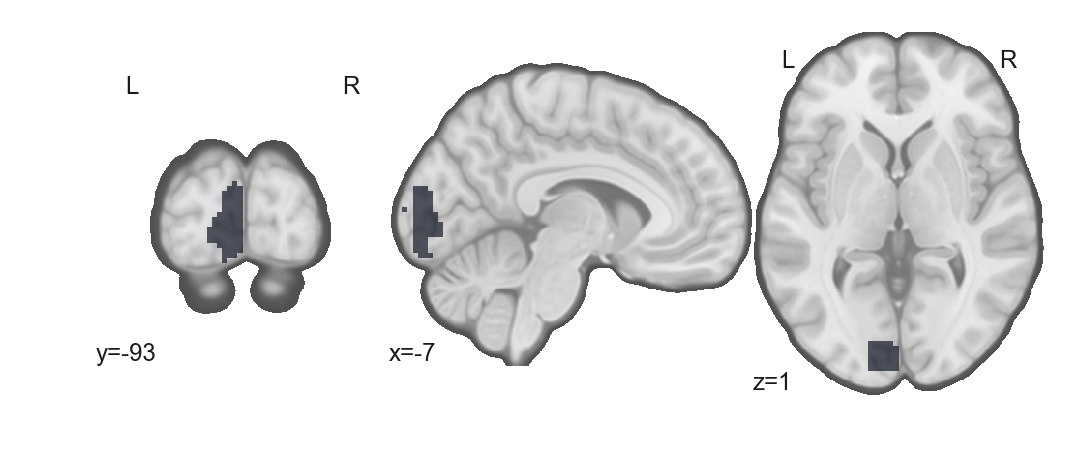

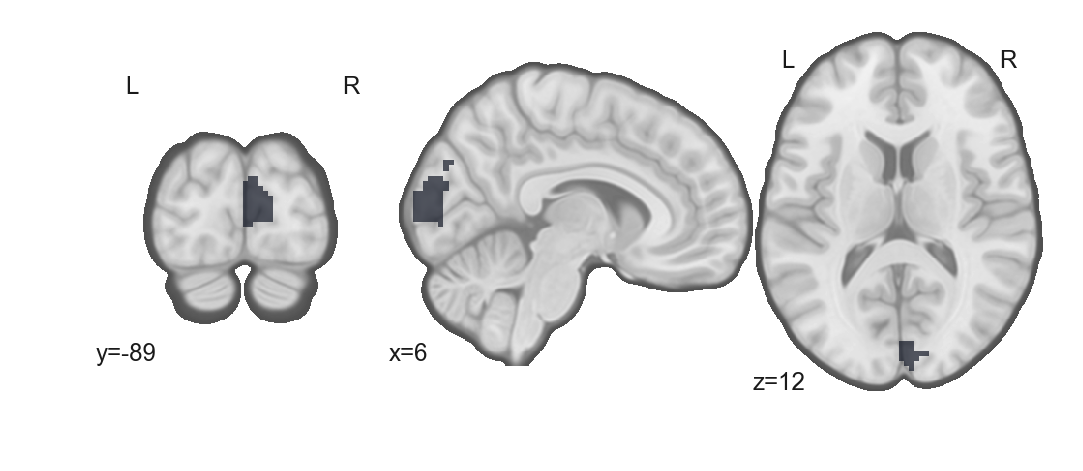

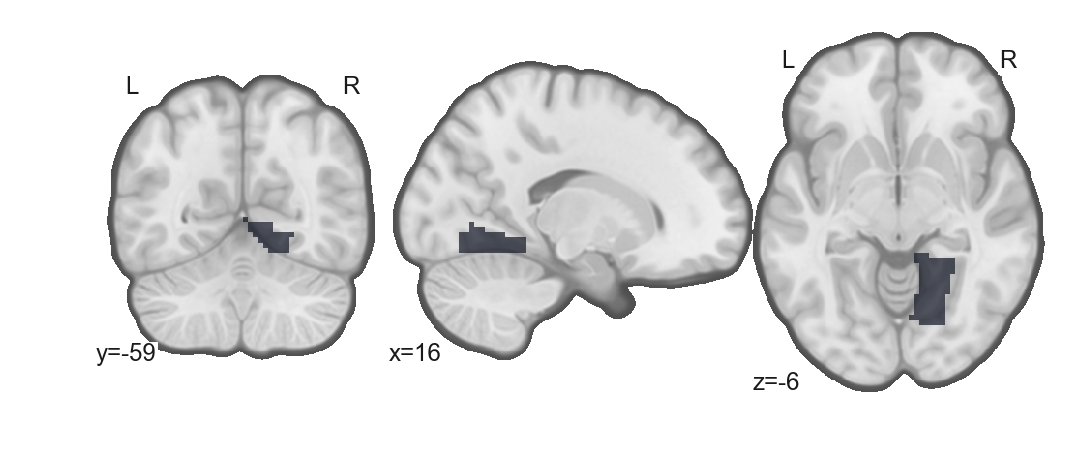

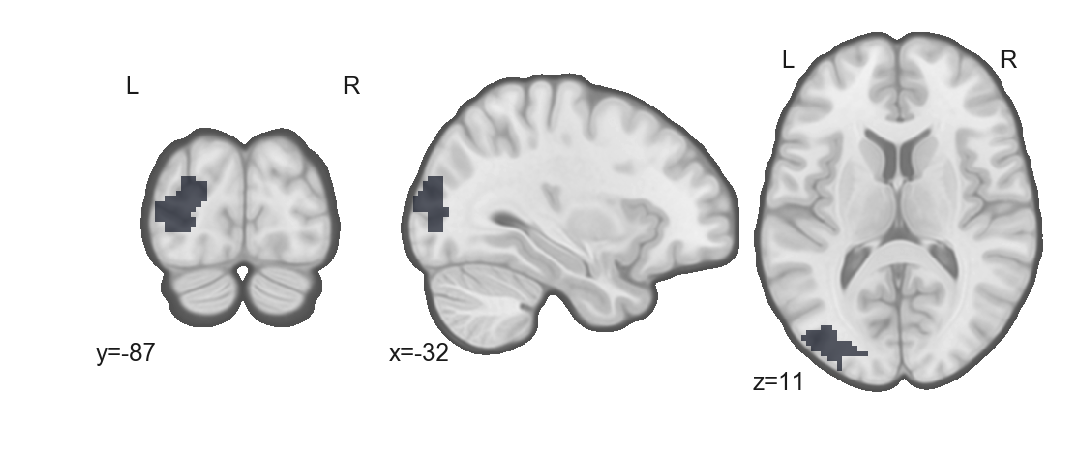

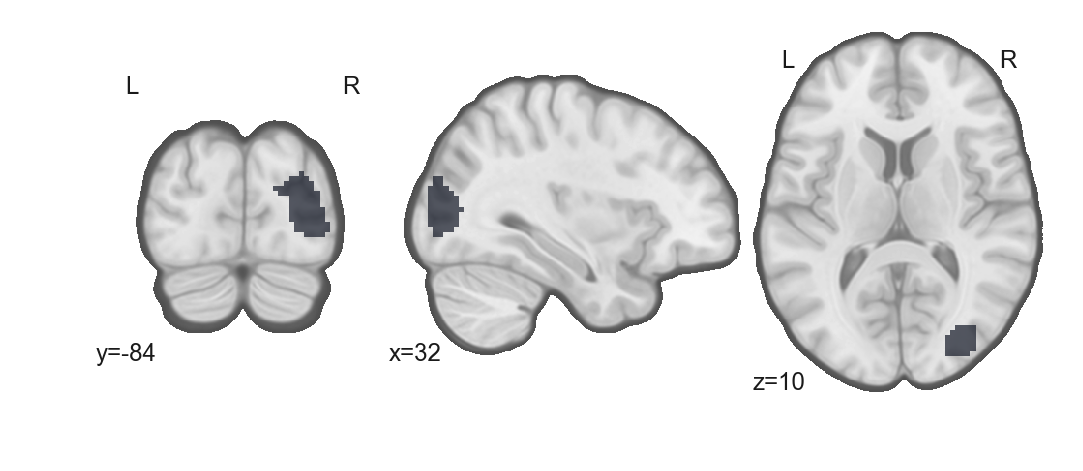

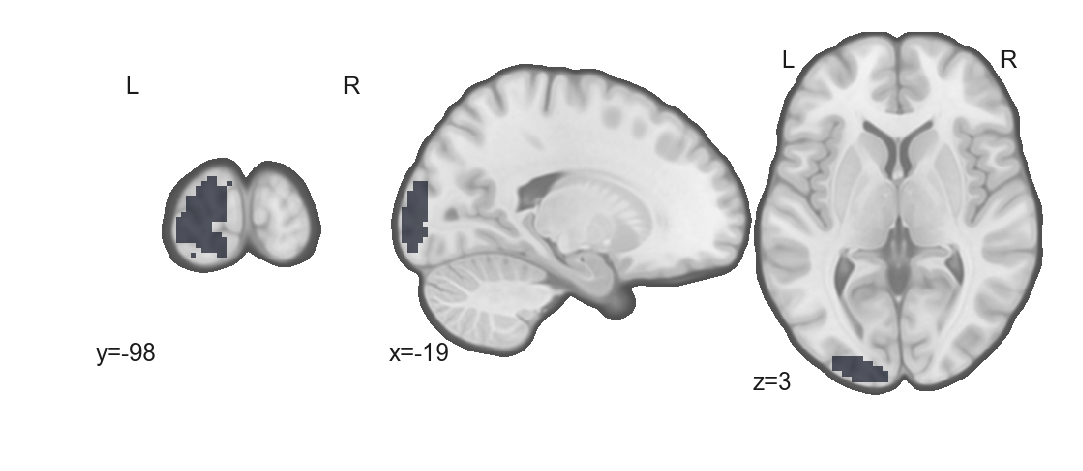

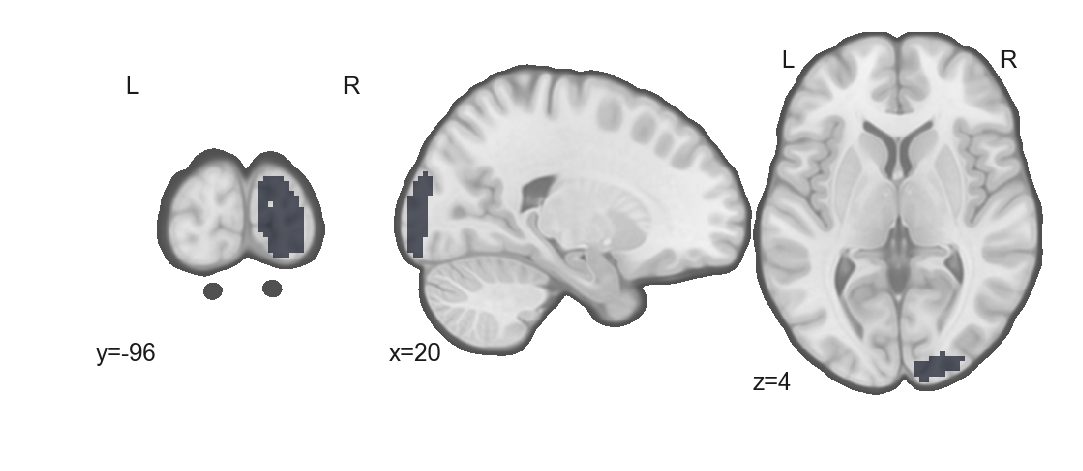

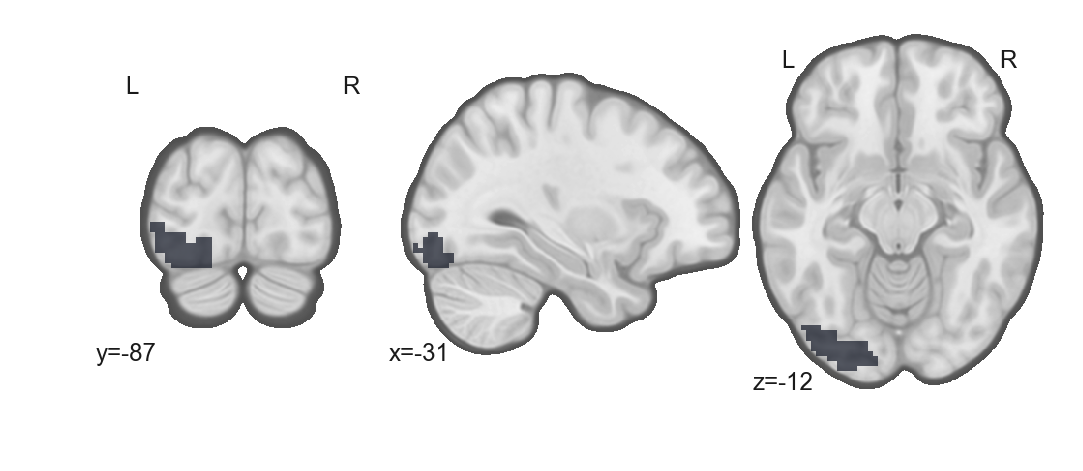

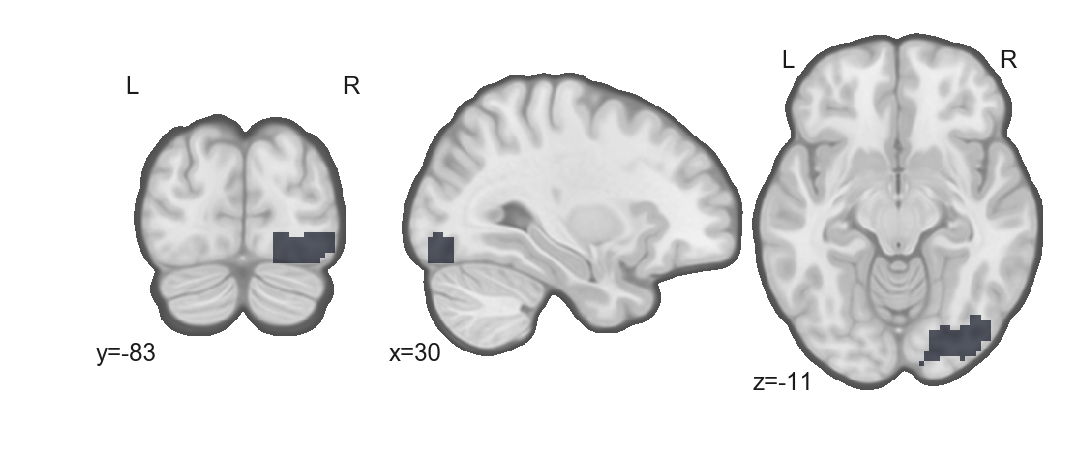

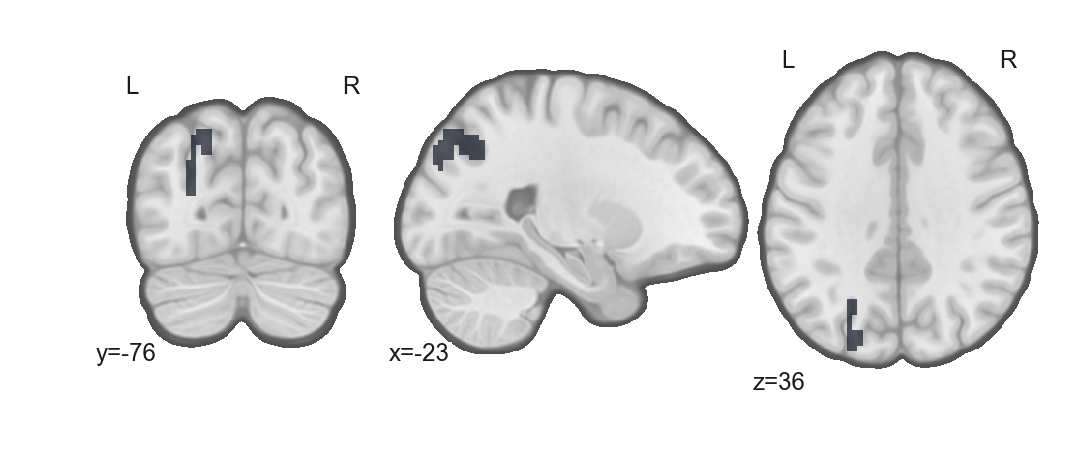

In [143]:
for roi_name, roi_img in zip(roi_names, roi_imgs):
    fig = nilearn.plotting.plot_roi(roi_img,
                          '/Users/eyshin/Desktop/MRIcroGL/mni152_2009bet.nii.gz', 
                          draw_cross=False, black_bg=False, cmap=cm)
    fig.savefig('20200317_%s.png' % (roi_name), dpi=300)

In [148]:
wit_df['roi_module'] = 'Visual'

In [183]:
sub_df = wit_df.groupby(['subj', 'roi_module', 'Mapping', 'Stage']).mean()
sub_df.reset_index(inplace=True)
sub_df = sub_df.sort_values(ascending=False, by='Mapping')
sub_df.reset_index(inplace=True)
sub_df = sub_df.sort_values(ascending=True, by='subj')
sub_df.reset_index(inplace=True)
sub_df

level_0  index  subj roi_module      Mapping  Stage  Mean Accuracy
0         38      3  GA01     Visual  Unpracticed   Late       0.596726
1         37      2  GA01     Visual  Unpracticed  Early       0.474206
2         80      0  GA01     Visual    Practiced  Early       0.588542
3        102      1  GA01     Visual    Practiced   Late       0.422371
4         41      7  GA02     Visual  Unpracticed   Late       0.474454
..       ...    ...   ...        ...          ...    ...            ...
115       42    115  GA42     Visual  Unpracticed   Late       0.290675
116       67    116  GA44     Visual    Practiced  Early       0.474702
117       64    117  GA44     Visual    Practiced   Late       0.665923
118       39    118  GA44     Visual  Unpracticed  Early       0.552083
119        0    119  GA44     Visual  Unpracticed   Late       0.562500

[120 rows x 7 columns]

In [186]:
pvals, tvals = [], []

sub_df2 = sub_df[(sub_df['Mapping'] == 'Practiced')]

early_mean_accs = sub_df2[sub_df['Stage'] == 'Early']['Mean Accuracy']
late_mean_accs = sub_df2[sub_df['Stage'] == 'Late']['Mean Accuracy']

res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)

print(res.pvalue, res.statistic)

0.03357127765985929 -2.2310819859908073


/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [187]:
pvals, tvals = [], []

sub_df2 = sub_df[(sub_df['Stage'] == 'Late')]

early_mean_accs = sub_df2[sub_df['Mapping'] == 'Practiced']['Mean Accuracy']
late_mean_accs = sub_df2[sub_df['Mapping'] == 'Unpracticed']['Mean Accuracy']

res = scipy.stats.ttest_rel(early_mean_accs, late_mean_accs)

print(res.pvalue, res.statistic)

0.09936997237203728 1.7024425748119334


/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/eyshin/.pyenv/versions/eyspy3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [178]:
def draw_avg_lineplot(roi_module, title):
    plt.figure(figsize=(7, 7))
    sub_df = wit_df
    
    sub_df = sub_df.groupby(['subj', 'roi_module', 'Mapping', 'Stage']).mean()
    sub_df.reset_index(inplace=True)
    sub_df = sub_df.sort_values(ascending=False, by='Mapping')
    sub_df = sub_df.sort_values(ascending=True, by='Stage')
    sub_df.reset_index(inplace=True)
    
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.6)
    plt.ylabel('Decoding Accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)

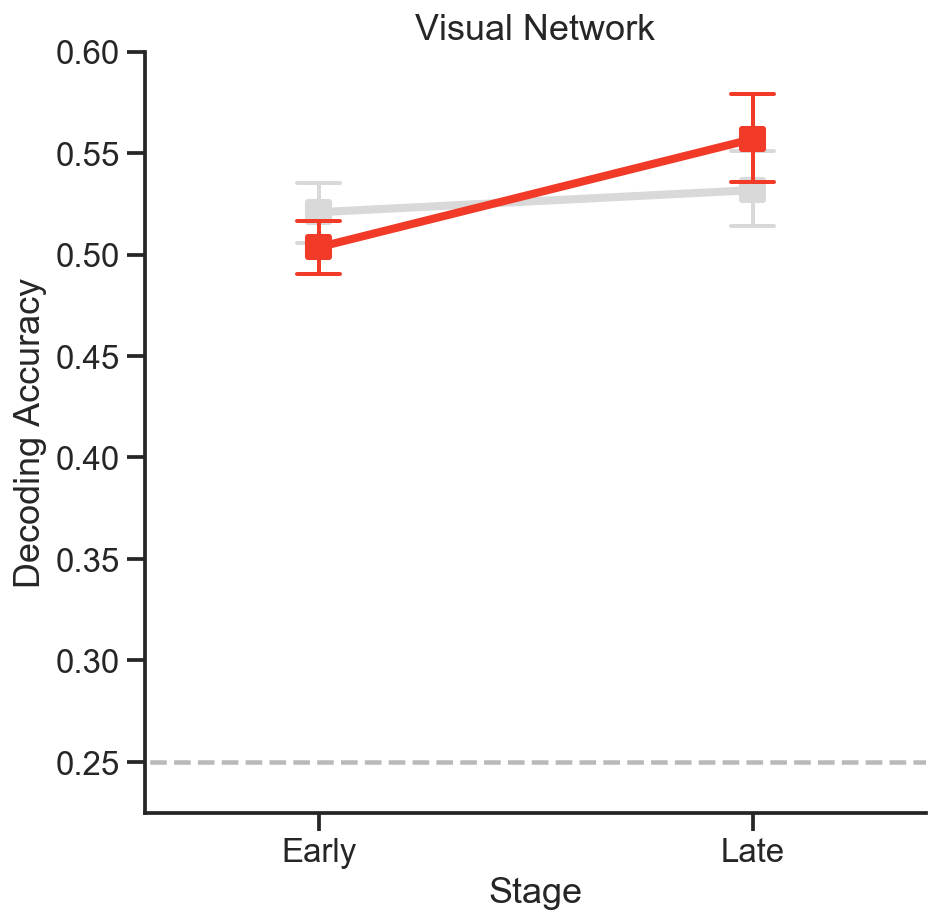

In [179]:
draw_avg_lineplot('Visual', 'Visual Network')

# Visual area, not averaged... as a whole ROI

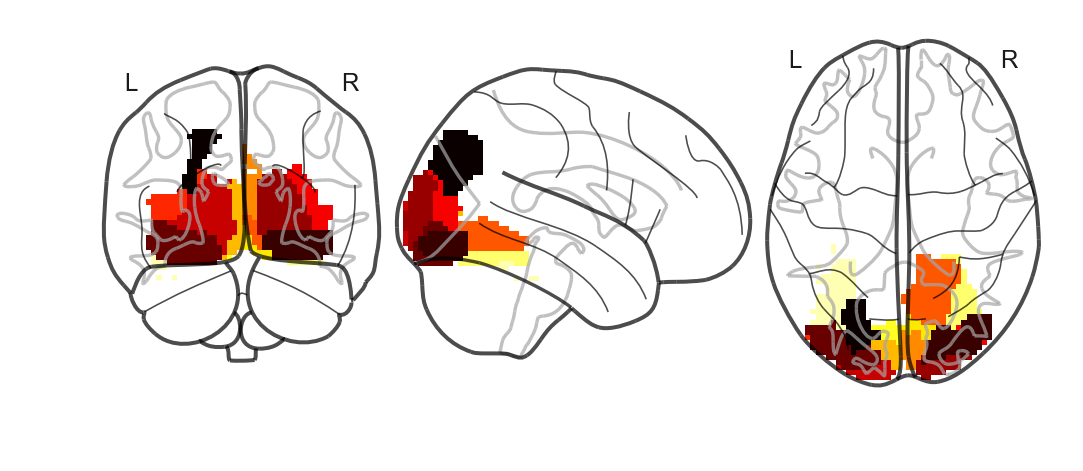

In [209]:
vis_roi_img = roi_imgs[0]

for i, roi_img in enumerate(roi_imgs[1:], 2):
    vis_roi_img = nilearn.image.math_img(img1=vis_roi_img, img2=roi_img, formula='img1 + img2 * %d' % i)
    
_ = nilearn.plotting.plot_glass_brain(vis_roi_img)

vis_roi_img.to_filename('20200317_vis_roi.nii.gz')

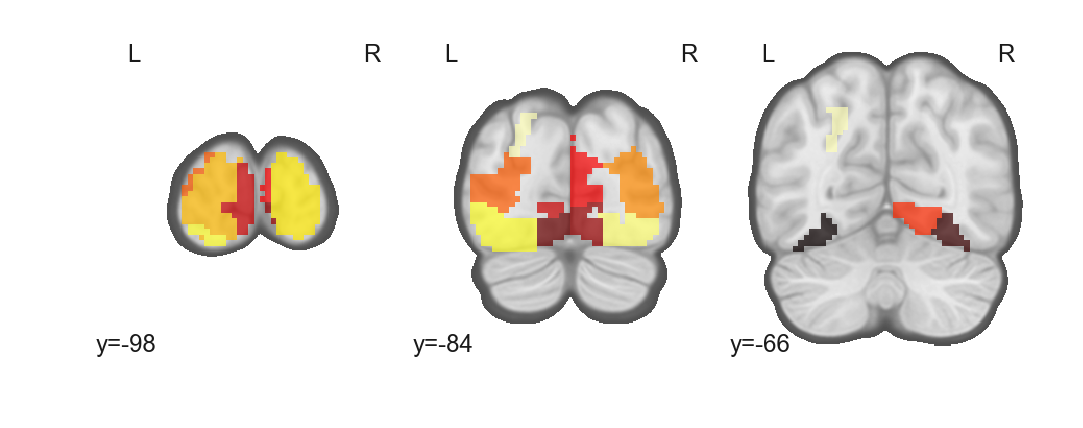

In [225]:
fig = nilearn.plotting.plot_roi(vis_roi_img, 
                                '/Users/eyshin/Desktop/MRIcroGL/mni152_2009bet.nii.gz', 
                                draw_cross=False, black_bg=False, vmax=15, cmap=plt.get_cmap('hot'),
                                cut_coords=(-98, -84, -66), display_mode='y')

In [104]:
with open('20191203_vis-area_dec-acc.pkl', 'rb') as file:
    results = pickle.load(file=file)

In [105]:
wit_results = results

wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

roi_name = 'yeo_network17_1'

for subj in subj_list[:30]:
    wit_df = wit_df.append({'subj': subj,
                    'roi_name': roi_name,
                    'Mapping': 'Unpracticed',
                    'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj, roi_name]),
                    'Stage': 'Early'}, ignore_index=True)

    wit_df = wit_df.append({'subj': subj,
                    'roi_name': roi_name,
                    'Mapping': 'Unpracticed',
                    'Mean Accuracy': np.mean(wit_results['pos', 'unpracticed', subj.replace('A', 'B'), roi_name]),
                    'Stage': 'Late'}, ignore_index=True)
        
    wit_df = wit_df.append({'subj': subj,
                    'roi_name': roi_name,
                    'Mapping': 'Practiced',
                    'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj, roi_name]),
                    'Stage': 'Early'}, ignore_index=True)

    wit_df = wit_df.append({'subj': subj,
                    'roi_name': roi_name,
                    'Mapping': 'Practiced',
                    'Mean Accuracy': np.mean(wit_results['pos', 'practiced', subj.replace('A', 'B'), roi_name]),
                    'Stage': 'Late'}, ignore_index=True)
    
wit_df.head()

subj         roi_name      Mapping  Mean Accuracy  Stage
0  GA01  yeo_network17_1  Unpracticed       0.649306  Early
1  GA01  yeo_network17_1  Unpracticed       0.791667   Late
2  GA01  yeo_network17_1    Practiced       0.819444  Early
3  GA01  yeo_network17_1    Practiced       0.559028   Late
4  GA02  yeo_network17_1  Unpracticed       0.802083  Early

In [72]:
def draw_lineplot(roi_name, title):
    fig = plt.figure(figsize=(7, 7))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.225, 0.9)
    plt.ylabel('Decoding accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)
    
    return fig

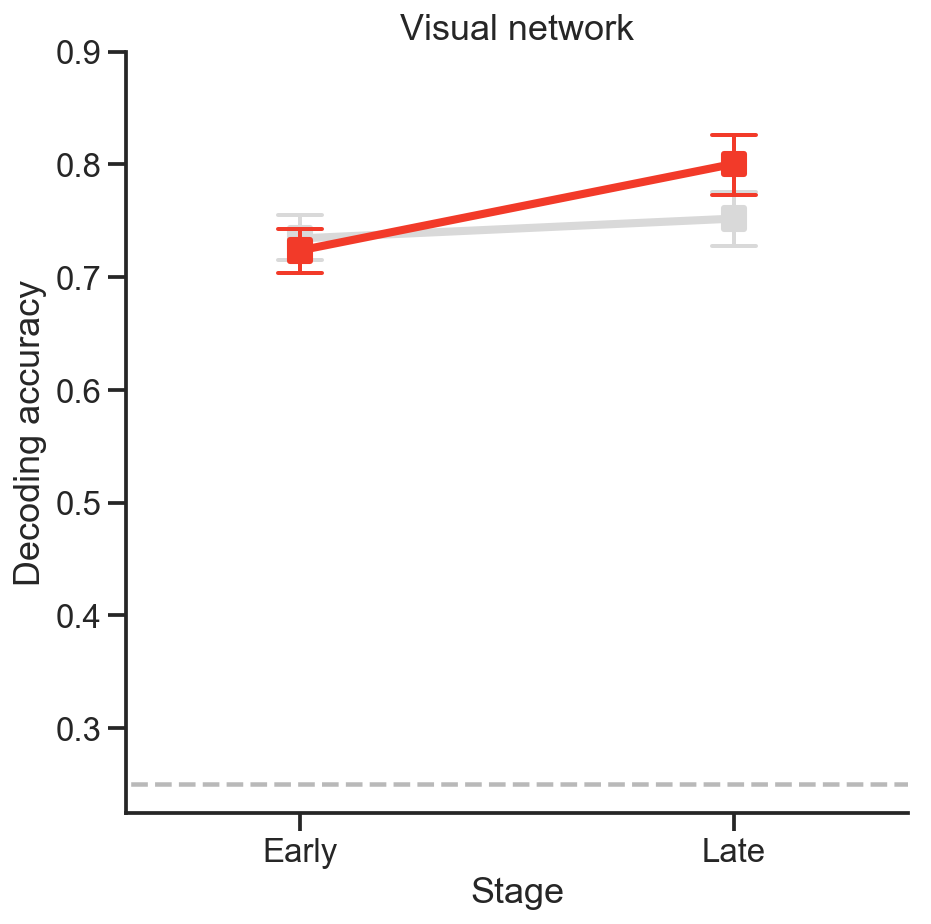

In [74]:
fig = draw_lineplot('yeo_network17_1', 'Visual network')
fig.savefig('20200317_%s_dec-acc.png' % (roi_name), dpi=300, bbox_inches='tight')

In [110]:
def draw_lineplot(roi_name, title):
    fig = plt.figure(figsize=(3, 5))
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, 
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    plt.plot((-0.5, 2), (1/4, 1/4), 'k--', alpha=0.3)
    plt.xlim((-0.4, 1.4))
    plt.ylim(0.25, 0.85)
    plt.yticks([0.25, 0.4, 0.55, 0.7, 0.85])
    plt.ylabel('Decoding accuracy')
    plt.legend().remove()
    #t, p = scipy.stats.ttest_rel(sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Early')]['mean_acc'],
    #                             sub_df[(sub_df['practiced'] == True) & (sub_df['stage'] == 'Late')]['mean_acc'])
    
    plt.title(title)
    
    return fig

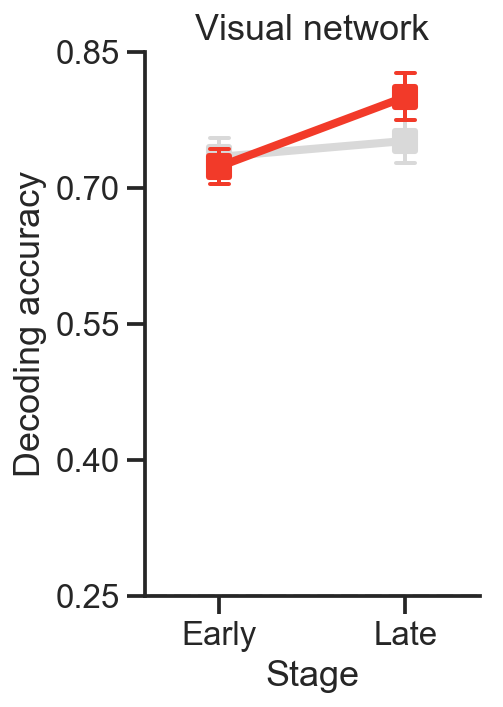

In [111]:
fig = draw_lineplot('yeo_network17_1', 'Visual network')